# 207 - Final Project - Facial keypoints detection
## Monday 6:30pm - Yacov Salomon
## Group: Ram Ben-David, Thomas Lurquin, Joe Mirza, Ziwei Zhao

## Library imports

In [1]:
# from matplotlib import pyplot
# from tensorflow.keras.utils import to_categorical

# baseline cnn model for mnist
from IPython.display import Markdown as md

import os
import time

import utils as ut
import utils_augment as aug
import importlib
from datetime import datetime
from datetime import timedelta

import numpy as np
from numpy import mean
from numpy import std
from pandas.io.parsers import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image

# WONDER IF THIS COULD BE A CONFLICT W/ANYTHING ELSE LOADED?
from tensorflow import keras
#from keras.utils.layer_utils import count_params

#tf.keras.backend.clear_session()

###########################
from keras import Model
from keras.models import Input
from keras.layers import concatenate
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from keras.datasets import mnist
#from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import Nadam
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import AlphaDropout # for selu activation function
from keras.models import load_model

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

Using TensorFlow backend.


## The inference problem and the data

Our project is based on the Facial Keypoints Detection challenge available on [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). 

#### **The inference problem:**
* Given a set of features (96 x 96 pixel representations of faces) predict the (x, y) (two dimensional coordinates)<br> location of a set of 15 facial feature-labels (e.g., center of the left eye, center of the right eye). 
* **The inputs**: 96 x 96 pixel arrays representing the image of a face in grayscale
* **The output**: 15 or fewer label (x,y) coordinate locations (in some images, all 15 keypoints won't fall within the<br> image and won't need to be labeled)

* **Objective:** Design and train a model that predicts label locations given an image of a face represented in a <br>96 x 96 array of pixel values 

#### **The data:**
* Kaggle provides us with two `.csv` files: `training.csv` and `test.csv`.

* The `training.csv` file contains 7049 events spanning 31 columns. For each event, the first 30 data<br> points capture the (x,y) coordinates of each of the 15 facial features and the last datapoint contains a string of <br>numbers which is the actual pixel image that the labels attach to. Note that not every image has all 15 facial<br> keypoints labeled (e.g. some are out of the frame and some are simply unlabeled).

#### **Kaggle results:**
* There are 175 entries in the Kaggle leaderboard. Those are ranked by the Root Mean Square Error of each<br> entrant's model.

* RMSE ranges from 1.28 to 52. The median RMSE is 3.59 and the top quartile RMSE is 2.06. 

#### **Business objective:**
* Identifying facial keypoints is useful as a building block for other applications. For instance, one may want to <br>track or analyze facial expressions, or one may want to track faces in a crowd. 

#### **Engineering limitations:**
* Size and quality of the training dataset
* Time to train the model
* Cost to train the model. GPUs and TPUs are expensive!

## Loading the data and EDA

In [2]:
#model_dir_name ='./models/'
#model_dir_name ='./submit_models/'
model_dir_name ='./saved_models/'

In [3]:
if os.uname()[1] == 'mac-mini.lan':
    data_dir = '/Users/rami/dataDownloads/W207_projects/final_project/facial-keypoints-detection/'
else:
    data_dir = ''
    
FTRAIN = data_dir + 'training.csv'
FTEST = data_dir + 'test.csv'
# FTRAIN

In [4]:
importlib.reload(ut)
importlib.reload(aug)

<module 'utils_augment' from '/home/jupyter/w207_final_project/W207_final_project/utils_augment.py'>

In [5]:
# Open the training.csv file to do EDA
test = False
fname = FTEST if test else FTRAIN

# get the rows with complete facial labels
df = ut.load_data(fname = fname ,complete = False)
print(df.shape)

training.csv
(7049, 31)


The dataset contains 7049 lines and 31 columns, one of the columns labeled "Image" seems to contain more<br> than one data point - let's take a look. Per Kaggle:
> Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are<br> 15 keypoints, which represent the following elements of the face

Therefore we expect, 15x2 + 1 columns .

The last column, `Image`, per Kaggle:
> The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row),<br> as integers in (0,255). The images are 96x96 grayscale pixel representations.

Let's take a closer look at the last column for line 1:


In [6]:
print(df['Image'][0])
print(df['Image'][0].shape)
print(len(df['Image'][0]))

[238. 236. 237. ...  70.  75.  90.]
(9216,)
9216


The data in the `Image` column was originally a space-delimited string containing the $96^2 = 9216$ values. The <br>`load_data` method above parsed it into a 96x96 array suitable for an image representation, which we can <br>see in grayscale below, after we've scaled them to between 0 and 1. 

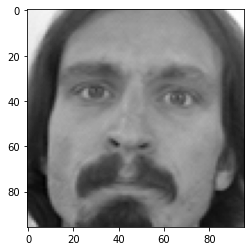

In [7]:
image0 = df['Image'][0]
image0 = np.array(image0, dtype='float')
# image0.reshape(96, 96)
image0 = image0 / 255
def resh_array(array):
    return np.reshape(array, (96, 96))

plt.imshow(resh_array(image0), cmap='gray')

## "EDA" on the labels

In [8]:
df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        7039.000000        7039.000000         7036.000000   
mean           66.359021          37.651234           30.306102   
std             3.448233           3.152926            3.083230   
min            22.763345           1.616512            0.686592   
25%            65.082895          35.900451           28.783339   
50%            66.497566          37.528055           30.251378   
75%            68.024752          39.258449           31.768334   
max            94.689280          80.502649           85.039381   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         7036.000000              2271.000000              2271.000000   
mean            37.976943                59.159339                37.944752   
std              3.033621                 2.690354                 2.307332   
min              4.091264                19.064954                27.190098   
25%             36.327681                58.039339                36.626283   
50%             37.813273                59.304615                37.878040   
75%             39.566729                60.519810                39.260348   
max             81.270911                84.440991                66.562559   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2267.000000              2267.000000   
mean                 73.330478                37.707008   
std                   3.405852                 2.881438   
min                  27.571879                26.250023   
25%                  71.716503                36.085523   
50%                  73.247824                37.639015   
75%                  75.015645                39.373489   
max                  95.258090                64.618230   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2268.000000               2268.000000  ...  7049.000000   
mean                  36.652607                 37.989902  ...    48.374186   
std                    2.350268                  2.311907  ...     4.280038   
min                    5.751046                 26.250023  ...    12.944699   
25%                   35.506126                 36.766783  ...    46.602370   
50%                   36.651562                 37.944075  ...    48.424713   
75%                   37.753571                 39.192917  ...    50.330437   
max                   70.714966                 69.808803  ...    89.438592   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  7049.000000          2269.000000          2269.000000   
mean     62.715884            63.285735            75.970714   
std       5.720567             4.079063             4.579724   
min      17.932414            22.923362            57.023258   
25%      59.292697            61.257143            72.875707   
50%      63.451421            63.178286            75.778689   
75%      66.492686            65.376243            78.879123   
max      95.935644            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2270.000000           2270.000000             2275.000000   
mean              32.900404             76.179768               47.975412   
std                3.964552              4.417814                3.323060   
min                2.245766             56.690208               12.605173   
25%               30.797646             73.256472               46.494571   
50%               32.982305             76.000592               47.905490   
75%               35.101302             78.956357               49.296488   
max               74.017993             95.510678               83.989082   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2275.000000                7016.000000   
mean                72.919443                  48.569472

We immediately note from the above that not all events contains data across the feature columns. Let's take a closer look:

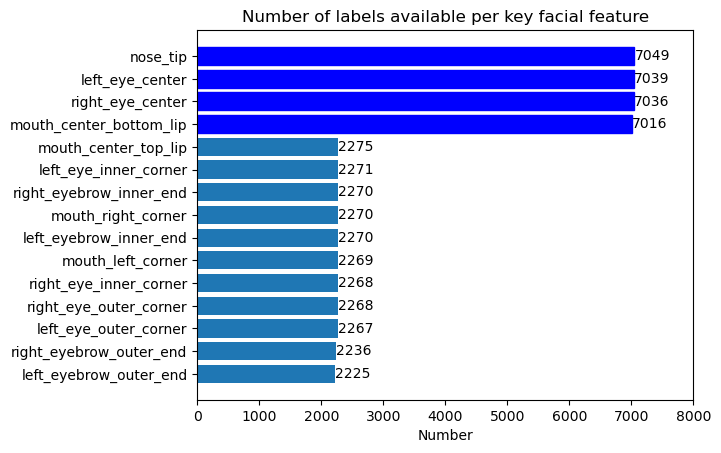

In [9]:
# plot a hz bar chart label availability by facial feature
df_plot = df.drop(['Image'], axis=1)

df_cnt = pd.Series.sort_values((df_plot.count(axis =0)), ascending = False)
# plotting
plt.rcdefaults()
# drop the _y's & _x's from the label names
afunc = np.vectorize(lambda x: x[:-2])
label_names = afunc(df_cnt.index[::2].to_numpy(),)

fig, ax = plt.subplots()
bars = ax.barh(label_names, df_cnt.to_numpy()[::2])

for bar in bars:
  width = bar.get_width() #Previously we got the height
  label_y_pos = bar.get_y() + bar.get_height() / 2
  ax.text(width, label_y_pos, s=f'{width}', va='center')

ax.set_xlim(0,8000)
for bar in bars[:4]:
  bar.set_color('b')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number')
ax.set_title('Number of labels available per key facial feature')
plt.show()

Looking at the above chart, only about 30% of the examples have all 30 keypoints labeled. The majority only have 8<br> labels. Those 8 would appear to include the x,y coordinates for the centers of the left and right eye, the nose tip and<br> the bottom center of the mouth. 
The left eyebrow outer (x,y) seems to have the most missing data. A mix of completely<br> and partially labeled examples presents some challenges, especially in the context of a relatively small training set. 

Our proposed approach is as follows:
- Train our *initial* models on only the fully labeled images

- Our final model will look to fill in the missing features by leveraging the data we DO have. The first stage will predict<br> the 4 most common facial keypoints, which are present in almost every training image. The second stage will use<br> the predictions for those 4 features, plus the image, to predict the remaining features. 

- In addition, we will look to augment our data, which we'll discuss later in this report. 


## "EDA" on the labels and features

Let's plot the labels superimposed on the features - starting with the first datapoint

In [10]:
labels_df = df.drop('Image', axis=1)
labels = labels_df.to_numpy()

Let's pull out the x's and the y's to create two arrays that can go into a .scatter(x, y)

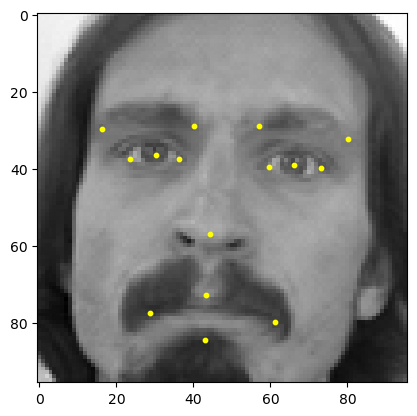

In [11]:
labels0_xcoord = labels[0][::2]
labels0_ycoord = labels[0][1::2]
plt.imshow(resh_array(image0), cmap='gray')
plt.scatter(labels0_xcoord, labels0_ycoord, s=10, color='yellow')

The above image, with the superimposed dots, is an example of a correctly (and fully) labeled image that we will use <br>to train our model. Other training images have as few as 3 keypoints labeled. 


# Methodology

## Objective

The Kaggle challenge objective is to provide label predictions with the lowest Root Mean Squared Error (hereafter<br> referred to as *RMSE*). In layman's terms, the goal is to minimize the square root of the average squared distance between<br> the pixels. 


## Loss Function

The loss function we will minimize is the Mean Squared Error (MSE) function. MSE also minimizes Root Mean Squared<br> Error (RMSE), our objective. 

## Model

Clearly, we are in a supervised learning setting with labeled events available for training. Our problem is also not one of <br>classification, but one of multioutput regression. We ruled out a number of models we learned in class (KNN, NB,<br> Log. Reg, etc.) and quickly gravitated towards the neural network family. We know that those types of models are<br> frequently used in image processing and recognition, but we also know that they can be complex to train and require a <br>lot of data, which may present a challenge given the size of our dataset. 

## Model Progression

Over the remainder of the notebook, we'll implement the following models:
1. **Model 1**: A vanilla neural network/MLP to serve as a baseline 
2. **Model 2**: An improved neural network, to see how much we can accomplish with that structure
3. **Model 3**: A Convolutional Neural Network (CNN)

Models 1-3 will have the same 80/20 train/dev split on the ~1500 completely labeled images. Our interest is in<br> comparing the performance of a CNN vs. our best neural network, operating on the same data, to see the difference in<br> their performance. 

4. **Model 4**: Is very similar to Model 3, trained on a significantly augmented dataset 

By using similar models (Models 3 and 4), we can see the benefit of augmenting our dataset. 

5. **Model 5**: A two step model using a CNN. 

Up until this point, we've only utilized completely labeled data. (The augmented data only leverages completely <br>labeled data as well). In this step, we'll look to leverage most of the rest of the data. 

In the first step, we'll create a model that predicts the 4 most common features using 4500 labeled images. In the
second<br> step, we will use those 4 predictions PLUS the image along with additional metadata to predict the remaining features in a <br>dual input model. The hope is that by utilizing most of the labeled examples across the two steps, we'll be able to create<br> a more effective model.


## Train, Dev and Test

As mentioned above, our first four models will only use the ~2000 completely labeled images. Of those, 20% will be <br>used for dev and hyperparameter tuning. 500 images are reserved for test, leaving about 1200 for training. In addition,<br> we will submit some of our models' label predictions to Kaggle for evaluation against the `test.csv` file. 

Our final, two-step model will use 3600 images for training, 900 for validation and 360 for test in the first step and<br> 1200/300/640 for the corresponding figures in the second step.


In [12]:
print(f"Total Labels: {df.iloc[:,:-1].count().sum() }")
print(f"Labels in Completely Labeled Images: {df.iloc[:,:-1].dropna().count().sum()}")

Total Labels: 106058
Labels in Completely Labeled Images: 64200


## Feature Engineering

There are 7,049 examples in the training dataset and 106,058 labels. The completely labeled images (with all<br> 15 x, y pairs for each facial keypoint labeled) only have 64,200 labels, or ~61% of the total. Not making use of <br>the other 39% of the labels would be a waste of valuable information. 

However, making use of them creates some challenges, which we will defer addressing until later in this <br>analysis. Until then we will use the completely labeled images.


One way of maximizing the usefulness of our data is through data augmentation. As will be shown later, both<br> neural networks and CNNs can struggle to learn patterns in images that are slightly different from the ones<br> they are presented in training. To address this, images are modified ('augmented') to provide greater variation<br> that, hopefully, these models can learn. The augmentations we used:

- **Mirroring**
  
  This involves flipping the image about the y-axis and provides some translational invariance. (Ability to<br> recognize patterns       that are shifted horizontally.)

- **Rotations**

  We found that images where the eyes were not level were more challenging for the model to label. To<br> attempt to train the model     to identify these labels more readily (create 'rotational invariance'), we added<br> images to our data that had been rotated randomly between -20 and 20 degrees and skewed the number <br>of images to produce more rotations above 5 degrees and below -5 degrees than were found in the dataset. <br>(More extreme rotations weren't frequent in the dataset, so we supplied more for the model to train on.)
  
- **Warping**

  We noticed higher RMSE values in y values than x values for some features like the tip of the nose, so we<br> performed a perspective change for images that causes warping/distortion. This changes the geometry <br>and distance between features of the faces in the image, giving the model more variety.
  
- **Contrast**

  We've observed that, to a minor degree, extreme contrast in images made it harder for the algorithm to predict<br> some labels, so we changed the contrast on some training images. 
 
**Other approaches considered or attempted**:
- Provided we could identify the center points of eyes with sufficient accuracy, we'd level the images in<br> preprocessing so that every image had eyes with a zero degree angle between them as well a centering<br> the eyes around the y-axis. These preprocessed images would then be processed in a subsequent<br> model. 
- Shifting, cropping and zooming out. The models seem to struggle with non-standard, off center<br> placement of key features. An augmentation that provided more images with these features might help it<br> learn to predict these labels more readily. 
- Preprocessing by removing information from the pixel map: we experimented with removing rows of pixels<br> around the edge of each image. Our hypothesis was that the edge of each image contains little information<br> relevant to the problem. This approach did not yield material improvements to our results. 

## **Model 1: Baseline Model**

We'll start with a simple neural network to establish a baseline with four hidden
layers with 200 nodes/layer.<br> We'll optimize our loss function using stochastic gradient 
descent and relu as our activation function.

Our training data will be all but 500 of our completely labeled examples, which we reserve
for test. 20% *of that<br> data* will be used for validation. 


In [13]:
# KILL BEFORE SUBMISSION

importlib.reload(ut)
importlib.reload(aug)

<module 'utils_augment' from '/home/jupyter/w207_final_project/W207_final_project/utils_augment.py'>

In [14]:
# if modeling a subset of the features, use facial_feature_vec to specify them and pass them
# to cols in subset_data_JM
# facial_feature_vec = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'nose_tip_x','nose_tip_y']
# would call as subset_data_JM(... cols = facial_feature_vec)

facial_feature_vec = list(df.columns[:-1])  # for all features
num_y_features = len(facial_feature_vec)

X, y = ut.subset_data_JM(df, test = False, n_complete=2140-500, n_partial=0, cols = None)

print(X.shape, y.shape, num_y_features)

(1640, 9216) (1640, 30) 30


In [15]:
# reshape the X data into a square, per image:

X_square = ut.make_square(X)

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("X_square.shape == {}; ".format(X_square.shape))

print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

X.shape == (1640, 9216); X.min == 0.000; X.max == 1.000
X_square.shape == (1640, 96, 96, 1); 
y.shape == (1640, 30); y.min == -0.920; y.max == 0.996


In [16]:
# set up the parameter dictionary
# CHANGE ALL TO PARAMS W/4
params = {
    'validation_fraction': 0.2,
    'augment': {'mirror': False, 'warp': False, 'rotate': False, 'contrast': False},
    'epochs': 1000,
    'num_y_features': num_y_features
}

In [17]:
# split the data
trainX_1, trainY_1, valX_1, valY_1 = ut.split_data(params, X_square, y)

# get test data
testX_1, testY_1 = ut.subset_data_JM(df, test = False, n_complete=2140, n_partial=0, cols = None)
testX_1, testY_1 = testX_1[-500:], testY_1[-500:]
testX_1 = ut.make_square(testX_1)


In [18]:
# build a param string
param_str = ut.build_param_str(params, n = trainX_1.shape[0])

./saved_models/Model_1_02_M0W0R0C0_1000_30_1312


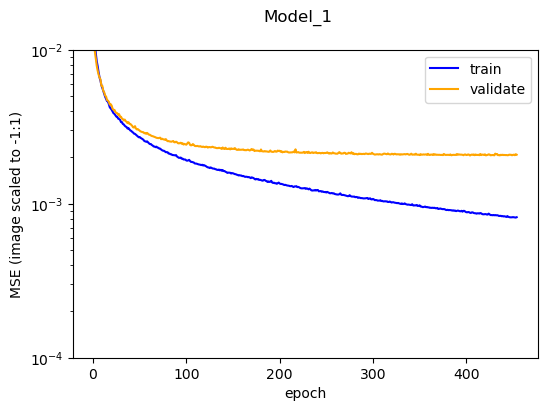

41/41 [==============================] - 0s 2ms/step - loss: 8.6144e-04
1.408811049115931 2.1770222273529907


In [19]:
def model_1(num_y_features):
    model = Sequential(name = 'Model_1')
    model.add(Flatten())
    
    model.add(Dense(200, activation = 'relu'))
    model.add(Dense(200, activation = 'relu'))
    model.add(Dense(200, activation = 'relu'))
    model.add(Dense(200, activation = 'relu'))

    model.add(Dense(num_y_features))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss = "mean_squared_error", optimizer = opt)
    return(model)

# placing these in the same code cell as the model definition allows you to rerun the 
# model without an error

build_model = False   # set to false if you want to reload an existing model
model_1 = model_1(num_y_features)
model_1, hist_1 = ut.run_model(model_1, trainX_1, trainY_1, valX_1, valY_1, params, build_model, model_dir_name, param_str)

# use history file to calculate model diagnostics (e.g. MSE, RMSE, etc. )
diag_1 = ut.return_diagnostics(model_1, hist_1,trainX_1, trainY_1, valX_1, valY_1 )


In [20]:
y_pred_1 = model_1.predict(testX_1)
test_rmse_1 = np.sqrt(np.mean((y_pred_1 - testY_1)**2))*48

m_list, d_list, t_list = [model_1], [diag_1], [test_rmse_1]
ut.print_diagnostics(m_list, d_list, t_list)



Model Comparison

			     |   Model_1   |
____________________________________________
         Train RMSE (pixels) |        1.41 |
    Validation RMSE (pixels) |        2.18 |
          Test RMSE (pixels) |        2.32 |
____________________________________________
      Loss Ratio (Val/Train) |        1.55 |
      Loss Ratio (Test/Train)|        1.64 
                             |             |
		      Epochs |         454 |
        Trainable Parameters |   1,970,030 |
____________________________________________


### **Model 1 Analysis**

<br>The RMSE on the validation data for our first model is above, and seems like a respectable baseline. 

- The rate of learning slows fairly dramatically after approximately 100 epochs. While we implemented<br> 
early stopping, we used a `patience = 50` argument which may have been, well, a bit *too* patient. 

- The model definitely shows signs of overfitting, as the training loss continues to decline while the<br>
validation loss ceases to. 

In our next model, we'll attempt to use a variety of techniques to get a conventional neural network to learn<br> more effectively, while at the same time not overfitting the data. 

Before we do, however, we'll look at the 6 images with the highest and lowest RMSE to see where the model<br> performs well, where it performs poorly and discuss how that might inform our strategy going forward. 


In [21]:
y_pred_1 = model_1.predict(trainX_1)
rmse_df = ut.calc_rmse_pixels(trainY_1, y_pred_1, facial_feature_vec)
# calculate the mean y values of the facial features
y_means = np.array(pd.DataFrame(trainY_1).mean(axis = 0))

# plot the best fit and the worst fit images
Npicture = 6

best_fit_index = rmse_df.\
                        sum(axis = 1).\
                        sort_values(ascending = True)[0:Npicture].\
                        index

worst_fit_index = rmse_df.\
                        sum(axis = 1).\
                        sort_values(ascending = False)[0:Npicture].\
                        index

Yellow = Truth, Red: Model, Blue: Average over all images


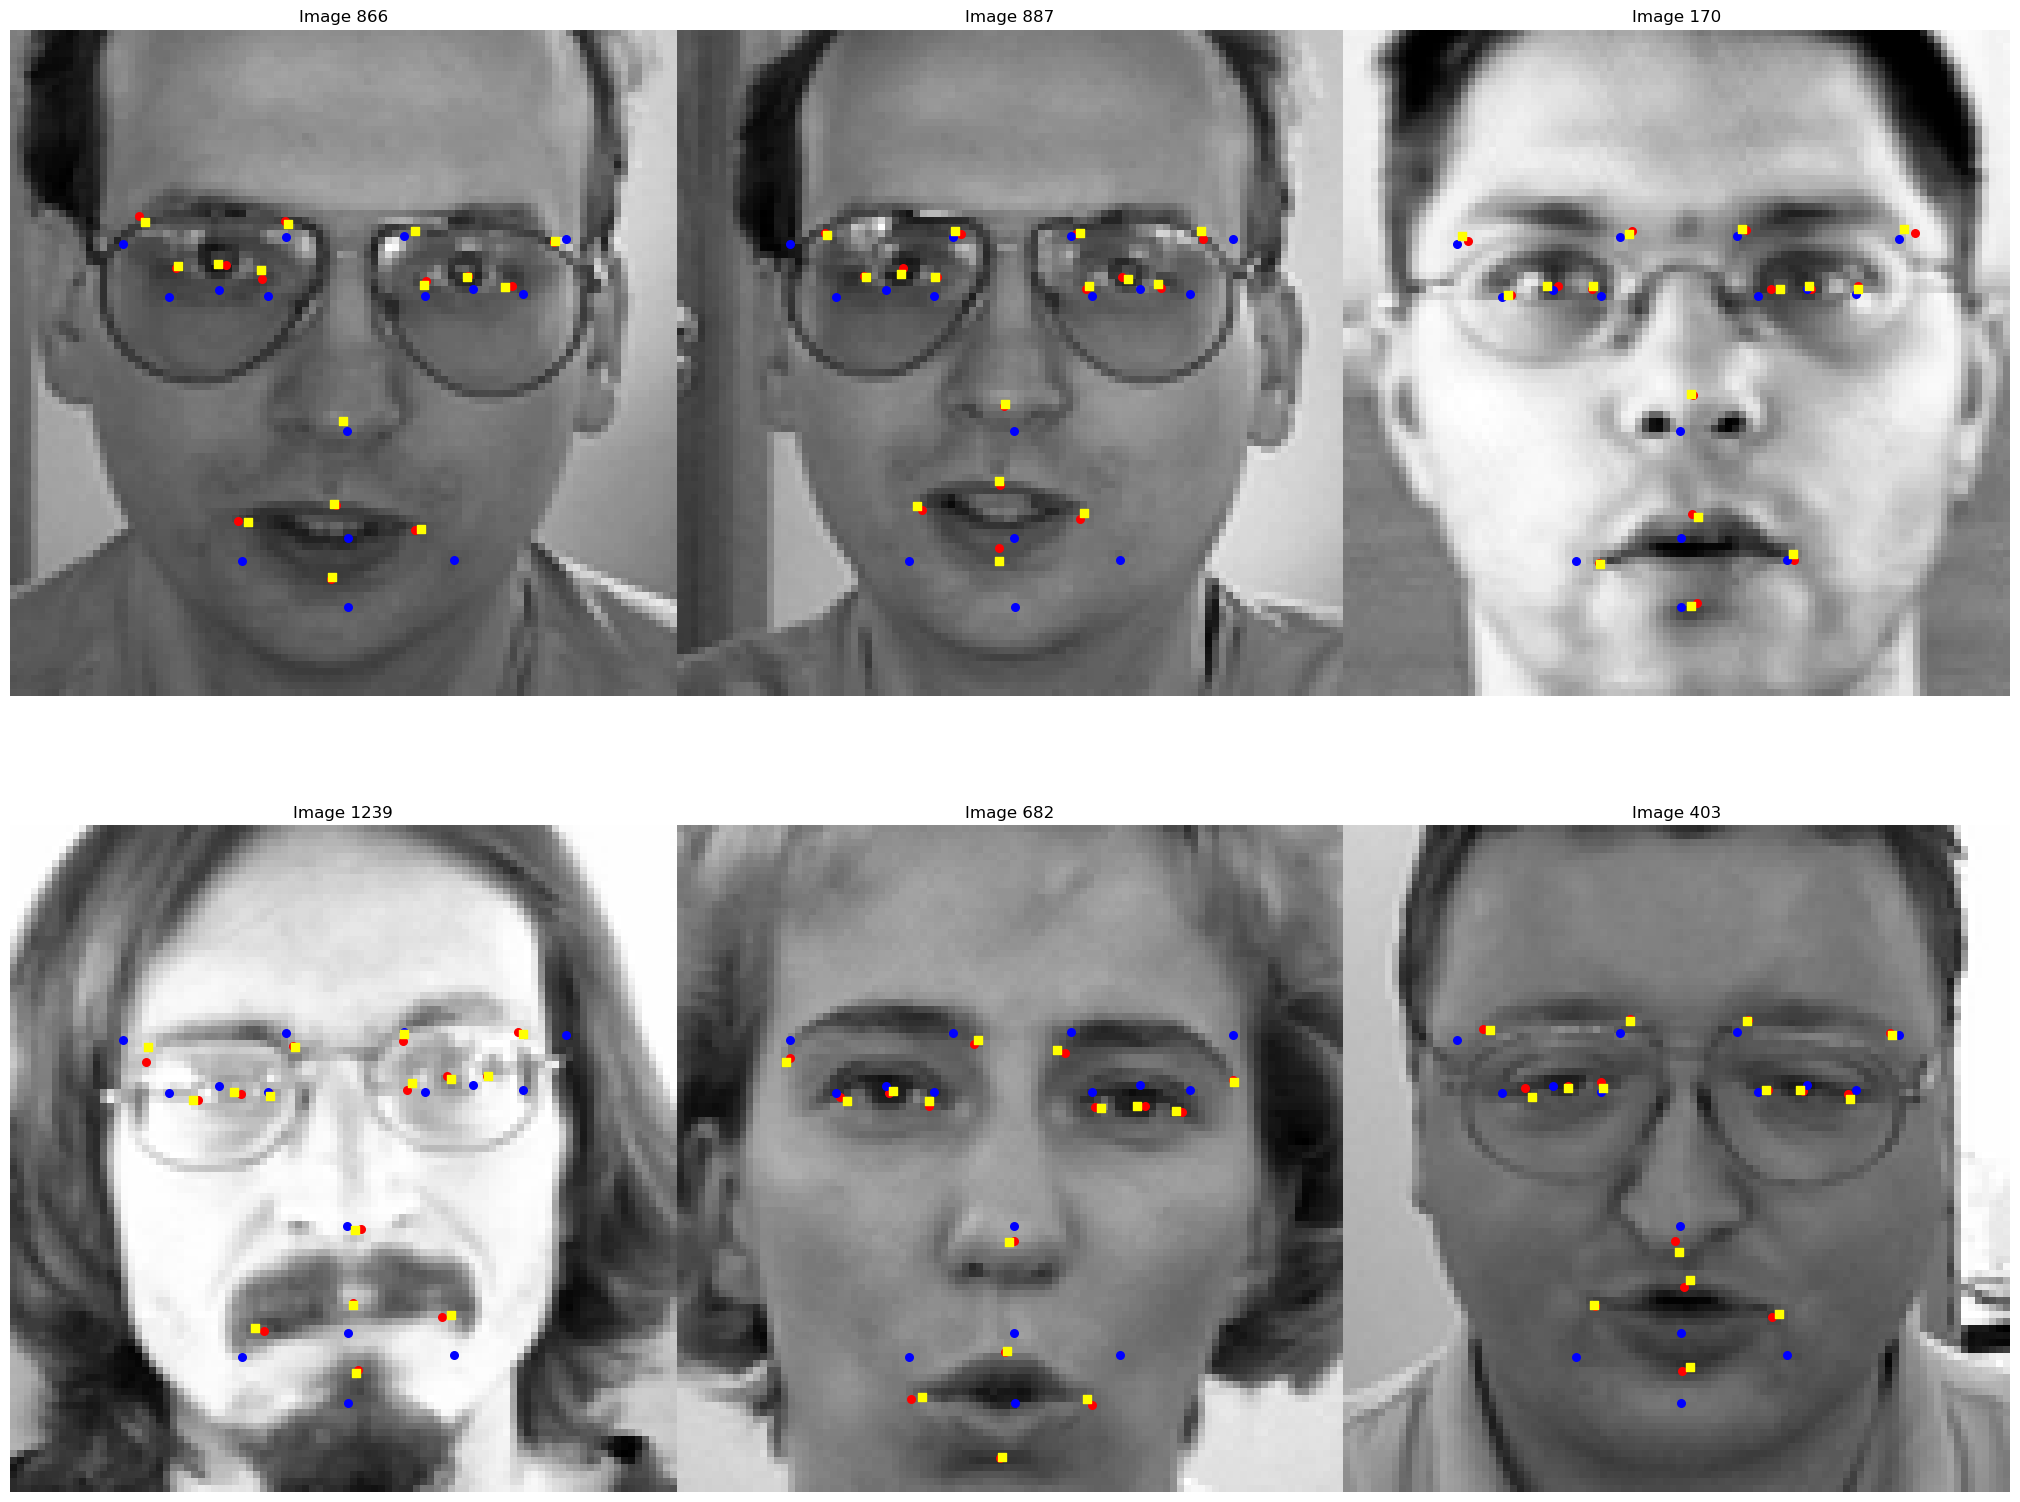

In [22]:
image_vec = best_fit_index
ut.plot_multiple_images(trainX_1, trainY_1, y_pred_1, y_means, image_vec)

The 6 images above had the *lowest* error, as measured by RMSE. The yellow pixels represent the actual/true labels, the red<br> pixels are the models' prediction and the blue labels are the mean predictions over the entire training set for those labels. 


**A few observations:**

- The angle between the eye centers is close to 0 and their faces show little rotation around the z-axis as well. <br>

- Most of the subjects' faces occupy approximately the same amount of each image, stretching from their chins at the<br> bottom of the image to the beginning of their forehead at the top of the image. 
- Most of the images have good contrast and lighting, making features easy to observe.<br>



**The following six images have the highest RMSE.**

Yellow = Truth, Red: Model, Blue: Average over all images


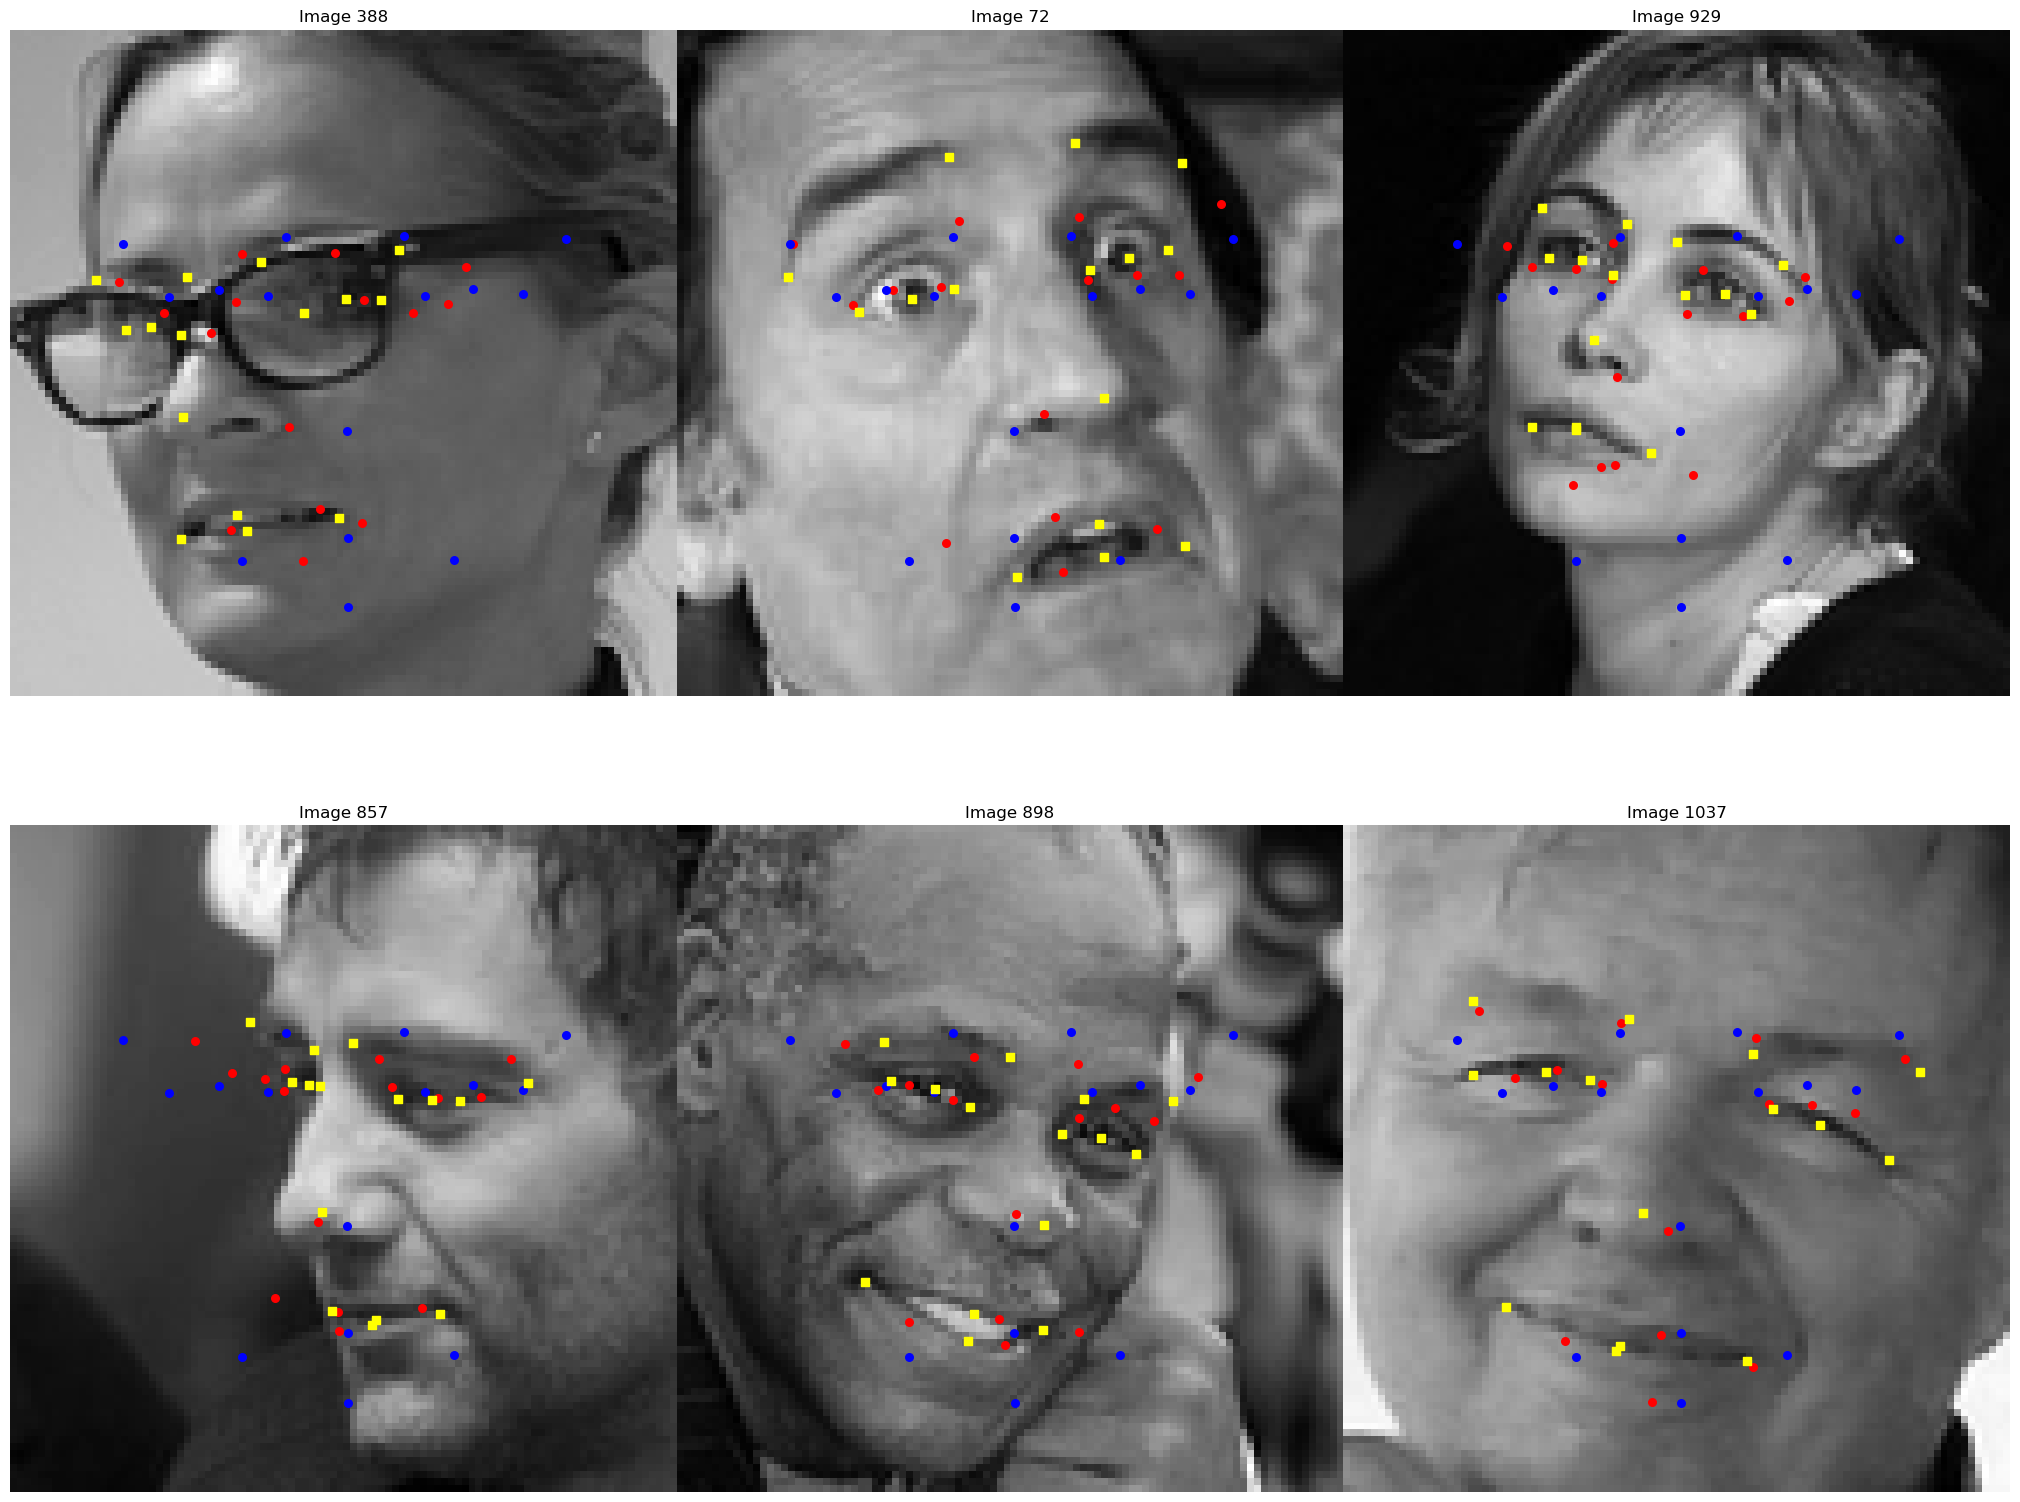

In [23]:
image_vec = worst_fit_index
ut.plot_multiple_images(trainX_1, trainY_1, y_pred_1, y_means, image_vec)

**Our observations regarding the six most poorly fit images:**

- When the model makes large errors, its predictions are often near the mean prediction for that feature over the <br>entire dataset. (The predicted red dots are near the mean blue dots.)<br>

- Several of the images are either rotated in the x, y plane, about the z-axis or both. We'll return to this later, but in<br> general, the greater of either type of rotation, the greater the RMSE for the image. <br>

- Other images that are fit poorly tend to be those where parts of the subject's face are out of the frame. <br>Sometimes that's because the subject is shifted and off center and in other instances the center of the subject's<br> face is filling a larger than normal portion of the image. 

Together, these observations and ones made on similar models informed our data augmentation strategy. Specificially,<br> we will add images that are:
- Randomly rotated between -20 and 20 degrees in the x,y plane<br>

- Warped by changing perspective, a bit like tilting the head forward or backwards. (e.g. Would effectively train the <br>algorithm on noses, for example, that appeared longer or shorter.)
- Flipped about the y axis 
- Had their contrast changed<br>

Furthermore, it seems likely we'd benefit from augmenting the data with images where we 'zoom' in and out and<br> where we shift a portion of the image outside of the 96x96 frame. 


**In order to acquire a more systematic understanding of our errors, we developed a set of plots to observe<br> these errors in in more detail and across several meta characteristics.**

As we explored the data, we used validation data for these error analysis charts. But as this is our final report, we switch <br>to our test set. 

### Error Analysis

The cost function we applied for the regression problem was minimizing the MSE.  Once a model has run, we'd like to<br> decompose the MSE into error types that contributed to the overall effect.  The analysis was carried out on the RMSE and we <br>focused on representing the units in pixels that provided a more intuitive and straightforward interpretation.

The error analysis was composed of two main ideas.  The first is to explore the RMSE by each of the 30 facial features. <br> Fig 1 is a boxplot distribution, per feature, of the RMSE of each image.  Most values are in the 1 to 2 pixel range, but per facial <br>feature, we observe differences between the x and y coordinates.  For example, for some features around the eyes, x values <br>(horizontal) have a larger error, while on the nose and mouth, it’s the y value (vertical) that has a larger relative error. This can <br>be understood as some of the features are more oval than circular.

To complement the RMSE by feature, we assess the RMSE for the overall image in Figs 2 through 8.  Here, each image <br>contributes once, with its total RMSE.  For each image, we calculate several meta-features, aggregating information across the <br>image.  In the plots, we’ve separated the data into the high RMSE (top half of the RMSE values per model, across all images) and <br>the low RMSE (the bottom half of the RMSE values).  This allows us to assess where the sources for large RMSE might be coming<br> from.


**The features we focused on were:**

1. **Tilt**: measured as the angle between the left and right eye centers.  Fig. 3 compares the true angle (x axis) vs. the angle<br> derived from the model (y axis).  Initially, when our models had not trained on a lot of images over many epochs, this was<br>the largest error, but with more training, this became less significant.  <br>

2. **Warping**: we used the actual distance between the eyes as a proxy for warping.  As the image is zoomed into, the distance <br>between the eyes increases.  Those images typically have larger errors.  See Fig. 4.
3. **Head Turn:** we measured the distance between each eye and the nose and then took the difference.  For images, where the<br> person is looking straight ahead, they should be equal and the difference is close to zero..  When they are turned away the<br> difference increases in magnitude.  See Fig. 5.
4. **Translation** (vertically and horizontally):  We measured the location of the midpoint between the eyes.  Images with larger<br> RMS tended to be further away from the center of the distribution.  See Fig. 6.   Horizontal translation typically turned out to<br> be one of the largest and most consistent sources of error.
5. **Intensity:**  we applied two measures that explored the differences in the lightning of the images.  The first was the mean <br>intensity, which is the average gray scale value across the image (Fig. 7).   The second was the standard deviation of the<br> intensity across an image (Fig. 8).  These features typically didn’t have a significant influence on the RMSE.

Given the spectrum of meta features we calculated, to assess, per model, which had the most influence, we ran a random forest<br> regression with the image  RMSE dependent on the 6 meta features.  In Fig. 2, we plot the relative significance of each meta feature<br> per model.  The higher the feature importance, the more influence the feature has on the regression model.

In the subsequent error plots, we apply the models to the test data as this is our final report, rather than a preliminary analysis. 

There is some underlying subjectivity to assessing the precise coordinates of features as well as some outright errors (e.g.<br> marking the edge of a person's glasses instead of the eyebrow, even though they were clearly separated) that will place a lower,<br> non-zero,  limit on the smallest achievable RMSE value.



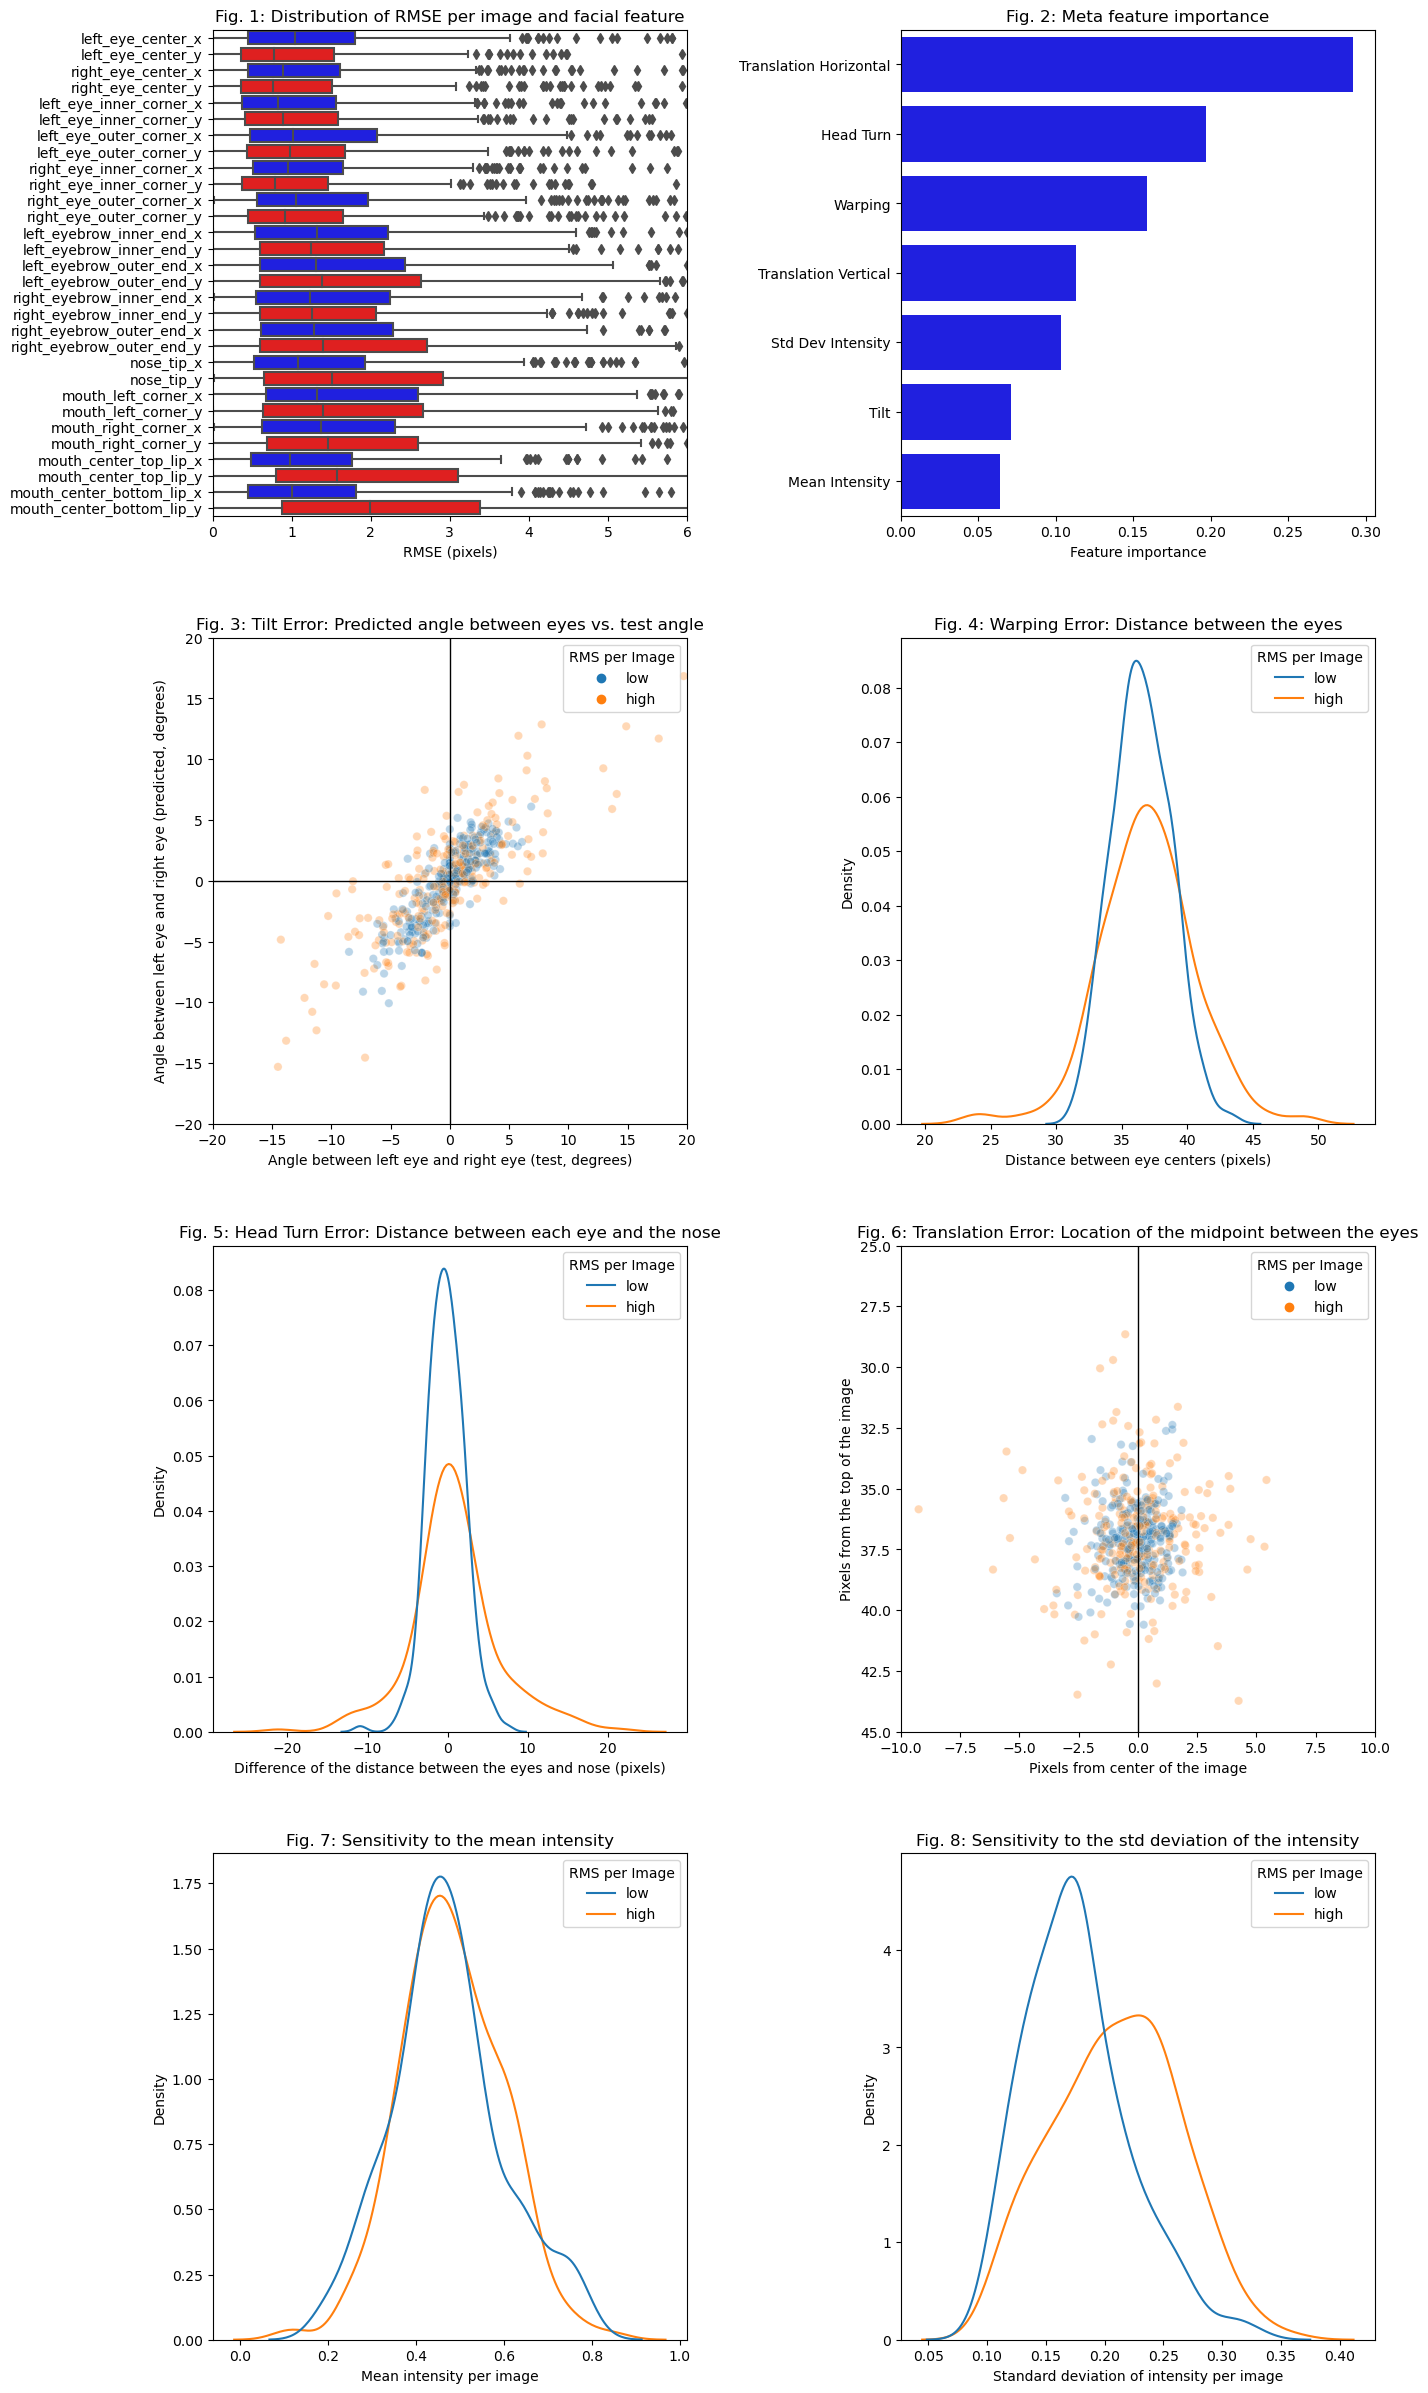

In [24]:
X_test, y_test = ut.subset_data_JM(df, test = False, n_complete=2140, n_partial=0, cols = None)
X_test, y_test = X_test[-500:], y_test[-500:]
X_test_square = ut.make_square(X_test)
y_pred = model_1.predict(X_test_square)
a, b = ut.error_analysis(X_test, y_test, y_pred, facial_feature_vec, plot_results = True)

### Model 1 Error Discussion:
    
The largest contributor to the RMS is the horizontal translation.  In Fig. 6 we observe more horizontal variance of <br>the orange  (high RMS)  dots vs. the blue (low RMS) dots.  Similar in the vertical direction, but less pronounced. <br> Both warping and head turn, have longer tailed distributions for the high RMS.<br>

While in Fig. 8 the sensitivity to standard deviation looks like it might be important, it doesn’t appear to be <br>significant in the feature importance chart (Fig. 2). This may be because the overall effect size is small or are <br>included in some of the other meta features. 



## **Model 2: Improving on our baseline with a better conventional<br> neural network/MLP**

In Model 2 we'll attempt to address some of the deficiences in Model 1 to see what we can accomplish with<br> a conventional neural network/MLP before turning to CNNs. (Note that the dataset is the same as Model 1.) <br>

- Model 1 appeared to overfit the data. We used regularization approaches such as BatchNormalization and <br>Dropout layers to improve our model's ability to generalize. We attempted to use L2 regularization as well,<br> but that was not as effective. 

- Model 1 learned quite slowly. To address that, we tried several optimizers before choosing the Nadam<br> optimizer. 

- Similarly, we tried different activation functions, including relu and selu (with AlphaDropout in place of<br> Dropout) before ultimately employing elu. 

- Regarding model structure, we began adding layers to see if we could improve the model's abilty to learn,<br> but paired them with BatchNormalization and Dropout in an attempt to preserve the model's abiilty to<br> generalize. The model we settled on had 10 hidden layers with 125 nodes/layer, 5 of which were paired with<br> 20% Dropout layers. 


In [25]:
importlib.reload(ut)
importlib.reload(aug)

<module 'utils_augment' from '/home/jupyter/w207_final_project/W207_final_project/utils_augment.py'>

In [26]:
facial_feature_vec = list(df.columns[:-1])  # for all features
num_y_features = len(facial_feature_vec)

X, y = ut.subset_data_JM(df, test = False, n_complete=2140-500, n_partial=0, cols = None)
print(X.shape, y.shape, num_y_features)

(1640, 9216) (1640, 30) 30


In [27]:
# reshape the X data into a square, per image:

X_square = ut.make_square(X)

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("X_square.shape == {}; ".format(X_square.shape))

print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

X.shape == (1640, 9216); X.min == 0.000; X.max == 1.000
X_square.shape == (1640, 96, 96, 1); 
y.shape == (1640, 30); y.min == -0.920; y.max == 0.996


In [28]:
# set up the parameter dictionary
# CHANGE ALL TO PARAMS W/4
params = {
    'validation_fraction': 0.2,
    'augment': {'mirror': False, 'warp': False, 'rotate': False, 'contrast': False},
    'epochs': 1500,
    'num_y_features': num_y_features
}


In [29]:
# split the data data
trainX_2, trainY_2, valX_2, valY_2 = ut.split_data(params, X_square, y)

# get test data
testX_2, testY_2 = ut.subset_data_JM(df, test = False, n_complete=2140, n_partial=0, cols = None)
testX_2, testY_2 = testX_2[-500:], testY_2[-500:]
testX_2 = ut.make_square(testX_2)


In [30]:
# build a param string   
param_str = ut.build_param_str(params, n = trainX_2.shape[0])

./saved_models/Model_2_02_M0W0R0C0_1500_30_1312


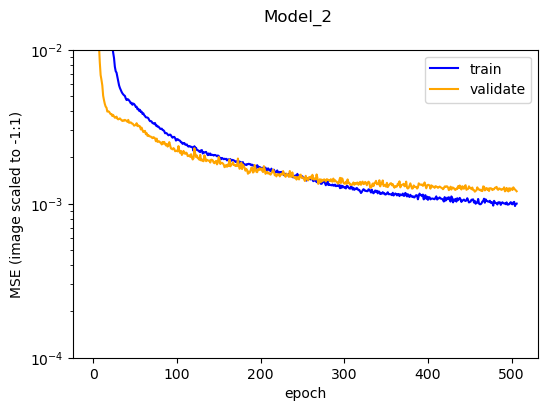

41/41 [==============================] - 0s 2ms/step - loss: 5.0874e-04
1.0826543122707912 1.660725215577051


In [31]:
def model_2(num_y_features):
    
    d_rate = 0.2
    n_nodes = 125
    
    model = Sequential(name = 'Model_2')
    model.add(Flatten())
    
    model.add(BatchNormalization())
    
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(BatchNormalization())
    
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(BatchNormalization())
    
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(BatchNormalization())
    
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(BatchNormalization())
    
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(BatchNormalization())
    
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(Dropout(rate = d_rate))
    model.add(BatchNormalization())
   
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(Dropout(rate = d_rate))
    model.add(BatchNormalization())
    
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(Dropout(rate = d_rate))
    model.add(BatchNormalization())
  
    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(Dropout(rate = d_rate))
    model.add(BatchNormalization())

    model.add(Dense(n_nodes, activation = 'elu', kernel_initializer = "he_normal"))
    model.add(Dropout(rate = d_rate))
    model.add(BatchNormalization())
    
    model.add(Dense(num_y_features))
    
    opt = keras.optimizers.Nadam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
    
    model.compile(loss = "mean_squared_error", optimizer = opt)
    return(model)

    
build_model = False   # set to false if you want to reload an existing model
model_2 = model_2(num_y_features)
model_2, hist_2 = ut.run_model(model_2, trainX_2, trainY_2, valX_2, valY_2, params, build_model, model_dir_name, param_str)
diag_2 = ut.return_diagnostics(model_2, hist_2,trainX_2, trainY_2, valX_2, valY_2 )


In [32]:
y_pred_2 = model_2.predict(testX_2)
test_rmse_2 = np.sqrt(np.mean((y_pred_2 - testY_2)**2))*48
m_list, d_list, t_list = [model_2, model_1], [diag_2, diag_1], [test_rmse_2, test_rmse_1]

ut.print_diagnostics(m_list, d_list, t_list)




Model Comparison

			     |   Model_2   |   Model_1   |
__________________________________________________________
         Train RMSE (pixels) |        1.08 |        1.41 |
    Validation RMSE (pixels) |        1.66 |        2.18 |
          Test RMSE (pixels) |        1.92 |        2.32 |
__________________________________________________________
      Loss Ratio (Val/Train) |        1.53 |        1.55 |
      Loss Ratio (Test/Train)|        1.78 |        1.64 
                             |             |             |
		      Epochs |         506 |         454 |
        Trainable Parameters |   1,318,587 |   1,970,030 |
__________________________________________________________


### **Model 2 Analysis**

**Results:**

- The RMSE showed quite a large improvement over Model 1. In fact, it was good enough to place in the middle<br> of the pack on Kaggle, despite only using complete image data and being a conventional neural network and<br> not a CNN. In the results shown above, the RMSE declined 17% percent on our test data by moving from <br>Model 1 to Model 2.

**What we learned:**
- Given a fixed number of nodes, deep rather than wide networks seem to learn more effectively and more <br>rapidly<br>

- This same network with 200 nodes/layer rather than the 125/layer above performed nearly as effectively<br> as one another, but the model above showed less evidence of overfitting and ran much more rapidly. It's striking <br>that Model 2 had 33% fewer parameters than Model 1 yet was signifciantly more effective due to regularization.
- The loss ratios and graphs are somewhat misleading because of dropout. Although we could have<br> adjusted our outputs to account for this, we instead just looked to see if training and validation performance<br> tracked each other. 
- Learning rate can matter quite a bit. Changing the rate from .01 to .001 resulted in a significant improvement <br>in performance and much less initial volatilty in the model's results on the validation data. 
- The 20% rule of thumb for dropout seemed like a pretty good guideline. We tried 10% and 30% with worse<br> results. 


### Model 2 Error Discussion:

In the interest of brevity, we'll forego a detailed examination of our errors until Models 3, 4 and 5. 



## **Model 3: Baseline CNN**

In Model 3, we implement a relatively conventional CNN structure, although with quite a bit of underlying complexity<br>
that we attempted to regularize with BatchNormalization, MaxPooling and Dropout, which worked quite 
well for us with <br>Model 2. 

Again, we're using the same set of completely labeled data as we used on Model 2, in order to see the gains we might<br> make with a CNN. 
  

In [33]:
importlib.reload(ut)
importlib.reload(aug)

<module 'utils_augment' from '/home/jupyter/w207_final_project/W207_final_project/utils_augment.py'>

In [34]:
facial_feature_vec = list(df.columns[:-1])  # for all features
num_y_features = len(facial_feature_vec)

X, y = ut.subset_data_JM(df, test = False, n_complete=2140-500, n_partial=0, cols = None)
print(X.shape, y.shape, num_y_features)

(1640, 9216) (1640, 30) 30


In [35]:
# reshape the X data into a square, per image:

X_square = ut.make_square(X)

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("X_square.shape == {}; ".format(X_square.shape))

print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

X.shape == (1640, 9216); X.min == 0.000; X.max == 1.000
X_square.shape == (1640, 96, 96, 1); 
y.shape == (1640, 30); y.min == -0.920; y.max == 0.996


In [36]:
# set up the parameter dictionary
params = {
    'validation_fraction': 0.2,
    'augment': {'mirror': False, 'warp': False, 'rotate': False, 'contrast': False},
    'epochs': 2000,
    'num_y_features': num_y_features
}

In [37]:
# split the data data
trainX_3, trainY_3, valX_3, valY_3 = ut.split_data(params, X_square, y)

# get test data
testX_3, testY_3 = ut.subset_data_JM(df, test = False, n_complete=2140, n_partial=0, cols = None)
testX_3, testY_3 = testX_3[-500:], testY_3[-500:]
testX_3 = ut.make_square(testX_3)


In [38]:
# build a param string  
param_str = ut.build_param_str(params, n = trainX_3.shape[0])

./saved_models/Model_3_02_M0W0R0C0_2000_30_1312


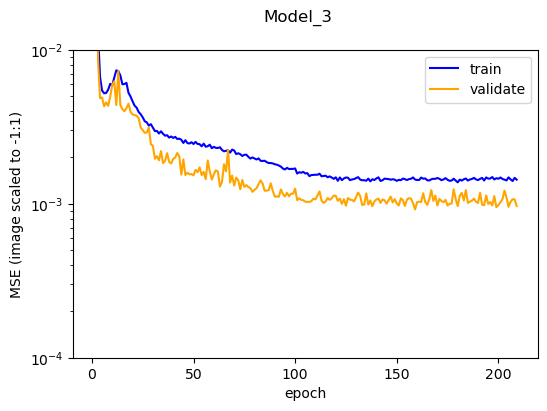

41/41 [==============================] - 1s 10ms/step - loss: 5.5020e-04
1.125903898939979 1.4546275983906702


In [39]:
def model_3(num_y_features):
    
    d_rate = 0.5
    n_nodes = 125
    

    model = Sequential(name = 'Model_3')
    
    # trying to condense the data somewhat, but using a lot of filters to start and very large convolution kernel 
    #model.add(Conv2D(128, 12, activation='relu', kernel_initializer='he_uniform', padding="same", input_shape=(96, 96, 1)))
    model.add(Conv2D(128, 12, activation='selu', kernel_initializer='lecun_normal', padding="same", input_shape=(96, 96, 1)))
    model.add(BatchNormalization())  
    model.add(MaxPooling2D((2, 2)))
    
    
    model.add(Conv2D(128, 2, activation='selu', kernel_initializer='lecun_normal', padding="same"))
    model.add(BatchNormalization())  
    model.add(Conv2D(128, 2, activation='selu', kernel_initializer='lecun_normal', padding="same"))
    model.add(BatchNormalization())     
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())             

    model.add(Conv2D(256, 2, activation='selu', kernel_initializer='lecun_normal', padding="same"))
    model.add(BatchNormalization())  
    model.add(Conv2D(256, 2, activation='selu', kernel_initializer='lecun_normal', padding="same"))
    model.add(BatchNormalization())     
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())             
              
    model.add(Flatten())   
    model.add(BatchNormalization())            
    
    #model.add(Dense(256, activation = 'relu')) 
    model.add(Dense(256, activation = 'selu', kernel_initializer='lecun_normal'))   
    model.add(BatchNormalization())    
    model.add(Dropout(rate = d_rate))
            
#     model.add(Dense(128, activation = 'selu', kernel_initializer='lecun_normal'))     
#     model.add(BatchNormalization())    
#     model.add(Dropout(rate = d_rate))
   
    model.add(Dense(64, activation = 'selu', kernel_initializer='lecun_normal'))   
    model.add(BatchNormalization())    
    model.add(Dropout(rate = d_rate))
              
    model.add(Dense(num_y_features))
                        
    opt = keras.optimizers.Nadam(learning_rate=.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")          
    #opt = SGD(lr=0.01, momentum=0.9)
    
    model.compile(loss = "mean_squared_error", optimizer = opt)
    #print(model.summary())
    return(model)

build_model = False   # set to false if you want to reload an existing model
model_3 = model_3(num_y_features)
model_3, hist_3 = ut.run_model(model_3, trainX_3, trainY_3, valX_3, valY_3, params, build_model, model_dir_name, param_str)
diag_3 = ut.return_diagnostics(model_3, hist_3, trainX_3, trainY_3, valX_3, valY_3 )


In [40]:
y_pred_3 = model_3.predict(testX_3)
test_rmse_3 = np.sqrt(np.mean((y_pred_3 - testY_3)**2))*48

m_list, d_list, t_list = [model_3, model_2, model_1], [diag_3, diag_2, diag_1], [test_rmse_3, test_rmse_2, test_rmse_1]
ut.print_diagnostics(m_list, d_list, t_list)




Model Comparison

			     |   Model_3   |   Model_2   |   Model_1   |
________________________________________________________________________
         Train RMSE (pixels) |        1.13 |        1.08 |        1.41 |
    Validation RMSE (pixels) |        1.45 |        1.66 |        2.18 |
          Test RMSE (pixels) |        1.59 |        1.92 |        2.32 |
________________________________________________________________________
      Loss Ratio (Val/Train) |        1.29 |        1.53 |        1.55 |
      Loss Ratio (Test/Train)|        1.42 |        1.78 |        1.64 
                             |             |             |             |
		      Epochs |         209 |         506 |         454 |
        Trainable Parameters |  10,076,382 |   1,318,587 |   1,970,030 |
________________________________________________________________________


### **Model 3 Analysis**

From a results perspective, Model 3, our first Convolutional Neural Network showed significant gains over Model 2,<br> our best MLP/conventional neural network. The RMSE on the validation data improved 13%, while the improvement<br> on the test data was 17%. 

- For the Model Comparison table above, one item the jumps off the page is the over 6x increase in trainable<br> parameters between Model 3 and Model 2. Those extra parameters resulted in quite a boost in performance. <br>It's quite remarkable that even with that big step up in complexity that the regularization from Dropout and Batch<br> Normalization (and from Max Pooling) resulted in little overfitting. 

- Setting the learning rate to .01 results in a bit of volatility in the results. That was one of the items we changed in<br> Model 4. 

- One area we performed some experimentation on was the size of the initial convolutional layer. We were wary<br> of compressing the data too much, too early and we experimented with filter sizes of 8x8, 12x12 and 16x16 before <br>seeing the best performance with 12x12.


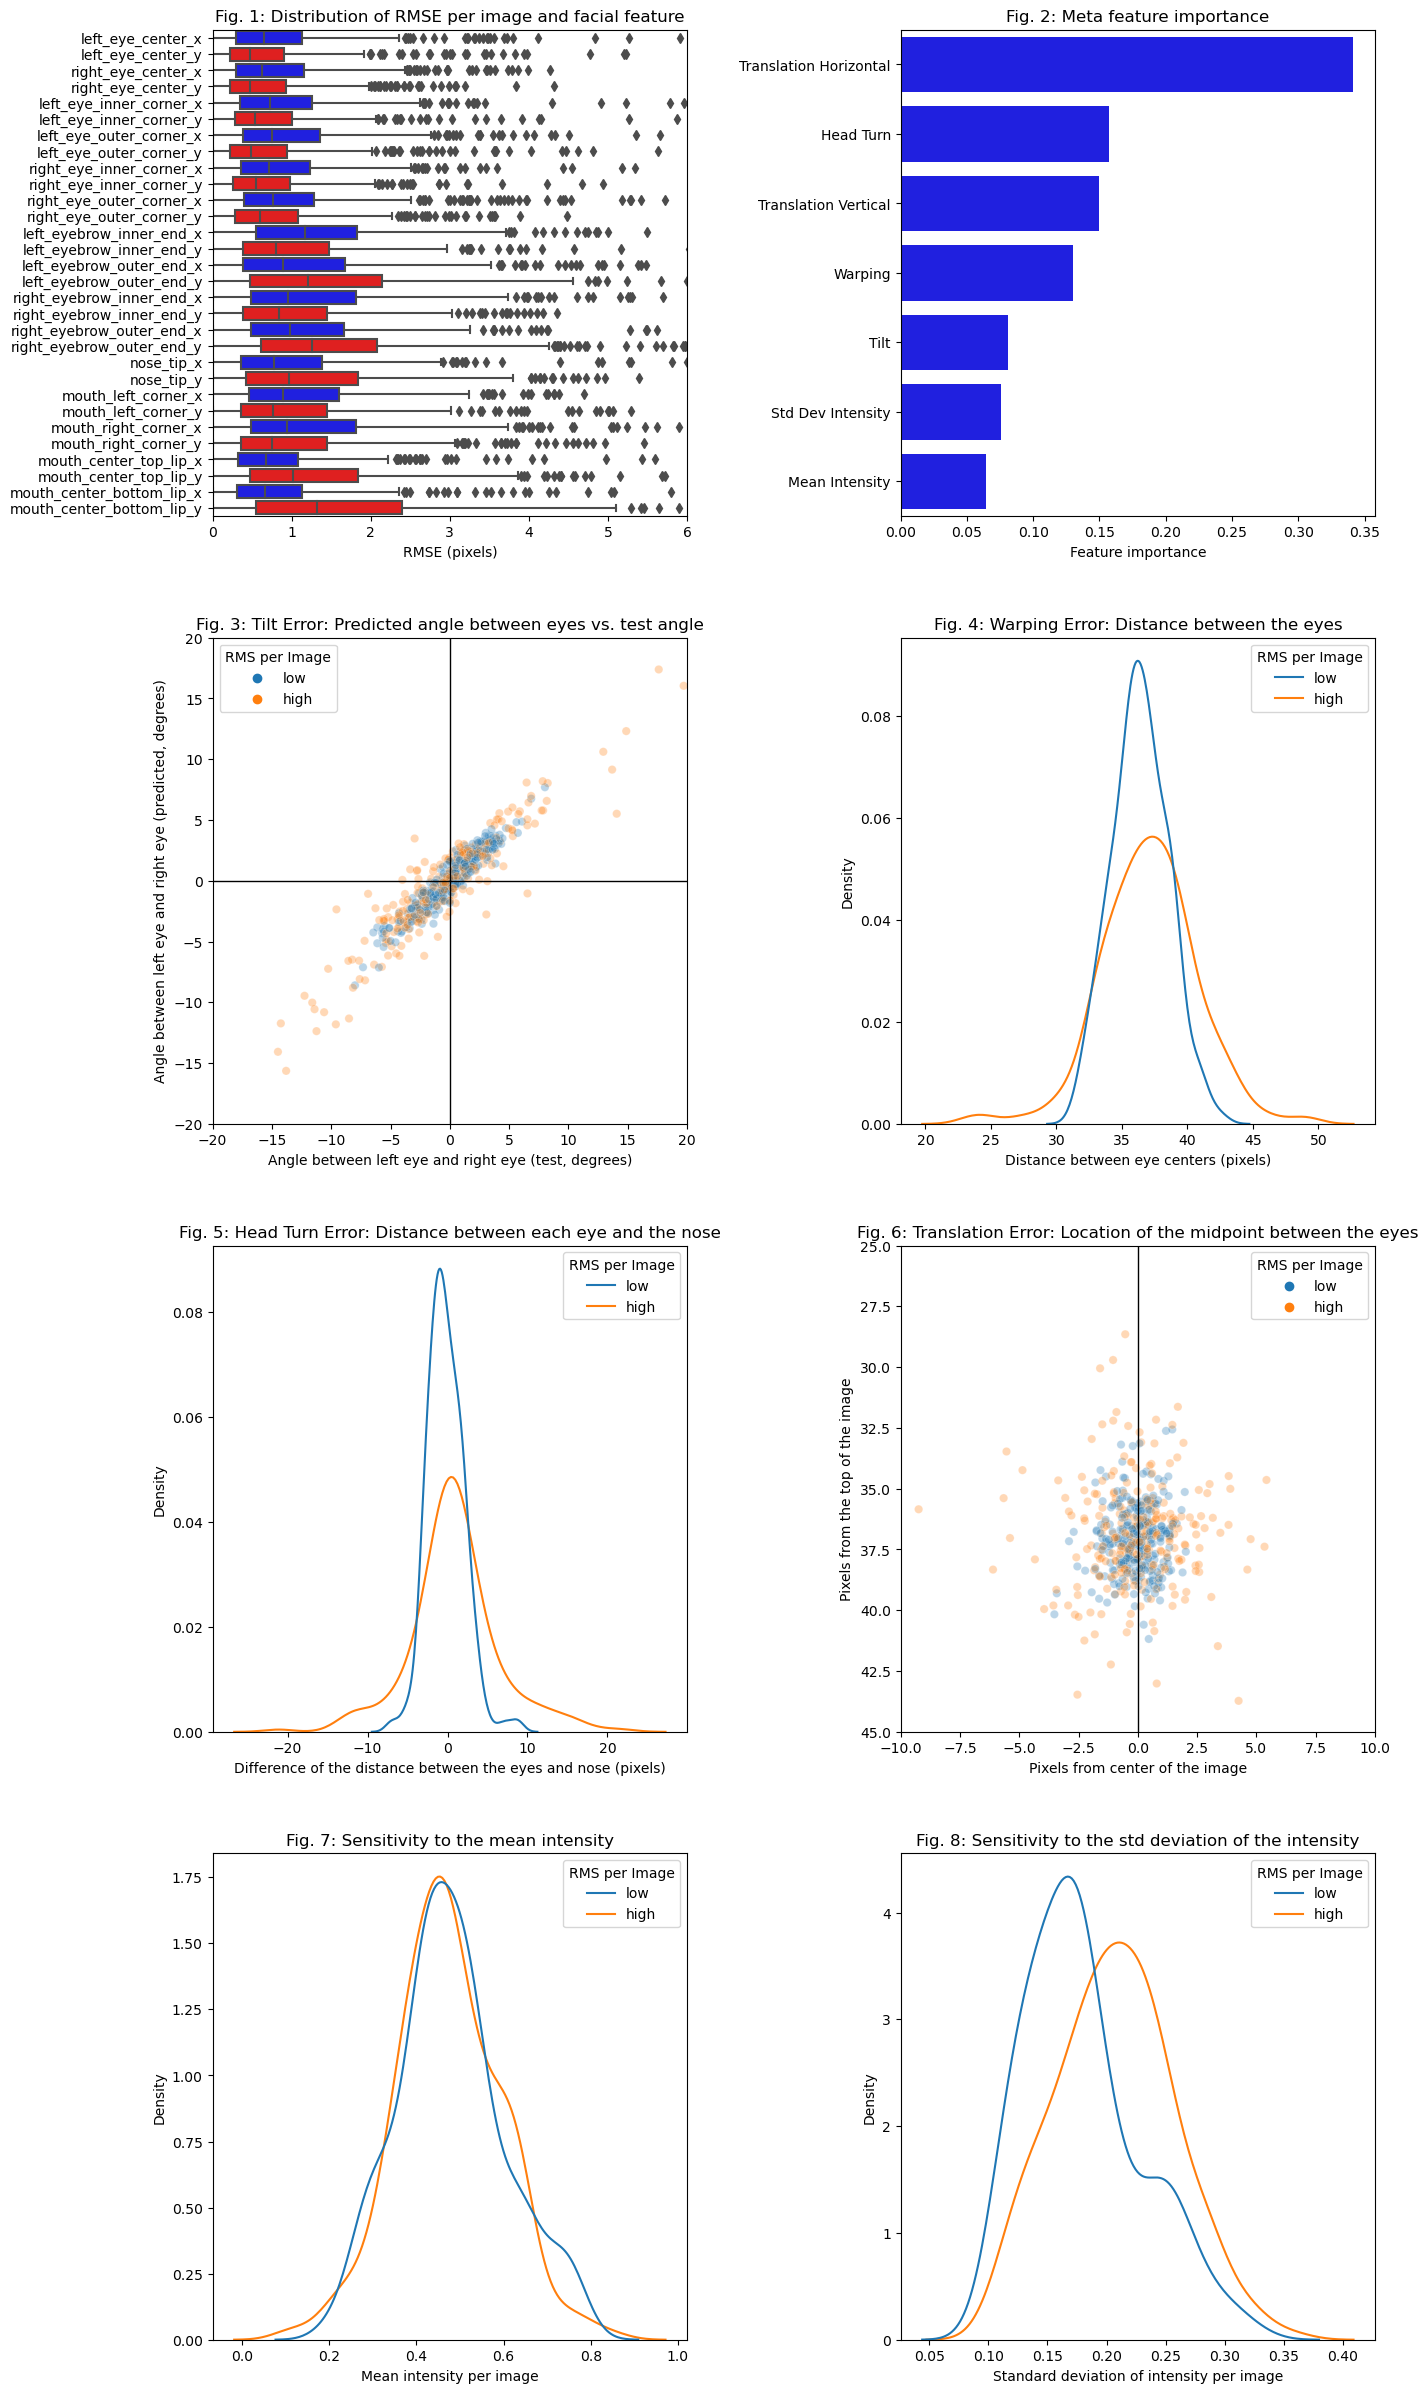

In [41]:
X_test, y_test = ut.subset_data_JM(df, test = False, n_complete=2140, n_partial=0, cols = None)
X_test, y_test = X_test[-500:], y_test[-500:]
X_test_square = ut.make_square(X_test)
y_pred = model_3.predict(X_test_square)
a, b = ut.error_analysis(X_test, y_test, y_pred, facial_feature_vec, plot_results = True)


### Model 3 Error Discussion:

Relative to model 1, the RMSE errors by feature are smaller.  However, we begin to observe that the errors in the y<br> coordinates are smaller than the x coordinate around the eyes.  Maybe at this resolution, we’re able to probe more of<br> the contrast structure within the image.

The meta-feature importance is about the same and will be for the remaining models as well.


## **Model 4: Similar to Model 3 but with augmented data**

Model 4 is similar to Model 3, but we layer on augmented data applied to the completely labeled examples. This results<br> in a ~4x increase in the size of the datset. 

In [42]:
importlib.reload(ut)
importlib.reload(aug)

<module 'utils_augment' from '/home/jupyter/w207_final_project/W207_final_project/utils_augment.py'>

In [43]:
# subset the data to create a working sample of n_train

facial_feature_vec = list(df.columns[:-1])  # for all features
#facial_feature_vec = list(df.columns[:-1])  # for all features

num_y_features = len(facial_feature_vec)
X, y = ut.subset_data_JM(df, test = False, n_complete=2140, n_partial=0, cols = None)

print(X.shape, y.shape, num_y_features)

(2140, 9216) (2140, 30) 30


In [44]:
# reshape the X data into a square, per image:

X_square = ut.make_square(X)

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("X_square.shape == {}; ".format(X_square.shape))

print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
X_square.shape == (2140, 96, 96, 1); 
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [45]:
# set up the parameter dictionary
# CHANGE ALL TO PARAMS W/4
params = {
    'validation_fraction': 0.2,
    'augment': {'mirror': True, 'warp': True, 'rotate': True, 'contrast': True},
    'epochs': 2500,
    'num_y_features': num_y_features
}


In [46]:
# split the data data
_trainX_4, _trainY_4, valX_4, valY_4 = ut.split_data(params, X_square, y)
#print(X_square.shape, y.shape, trainX.shape, trainY.shape, testX.shape, testY.shape)

# get test data
testX_4, testY_4 = ut.subset_data_JM(df, test = False, n_complete=2140, n_partial=0, cols = None)
testX_4, testY_4 = testX_4[-500:], testY_4[-500:]
testX_4 = ut.make_square(testX_4)


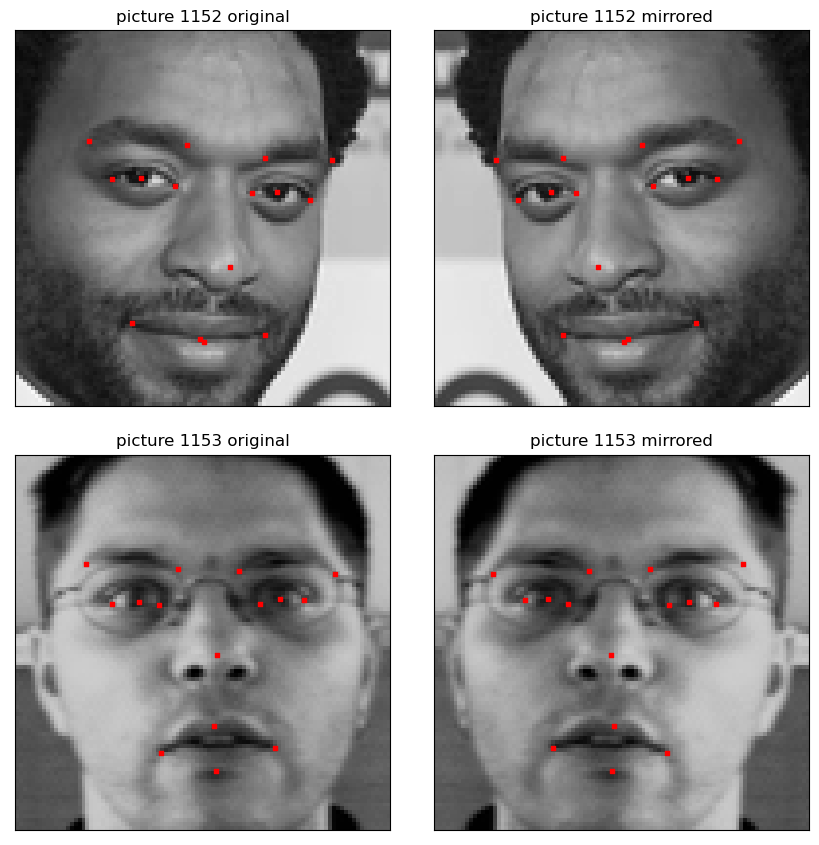

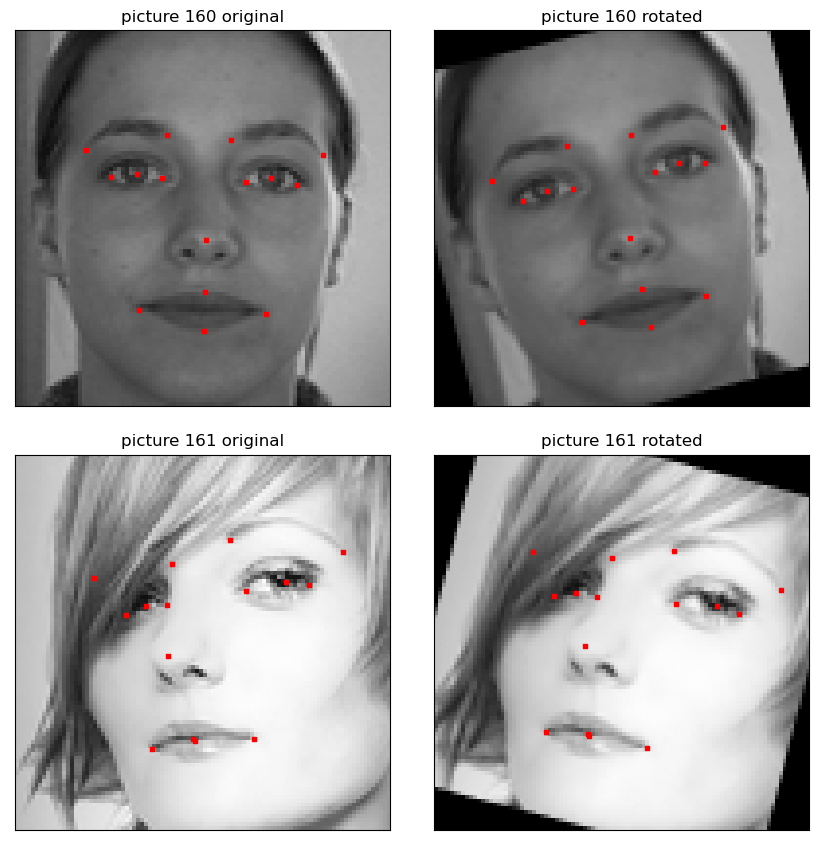

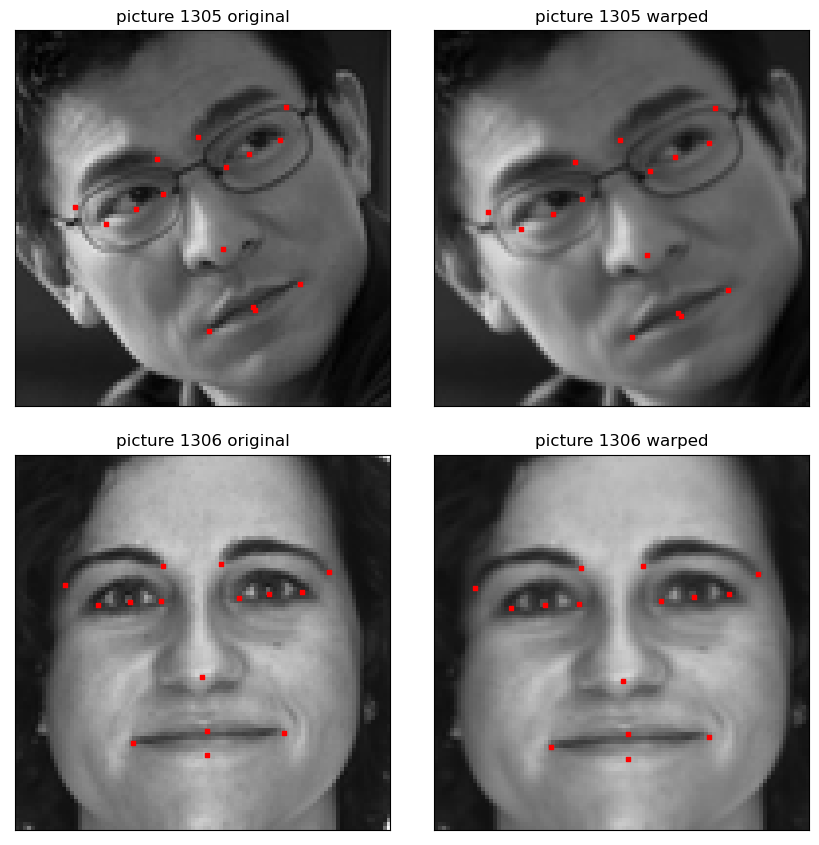

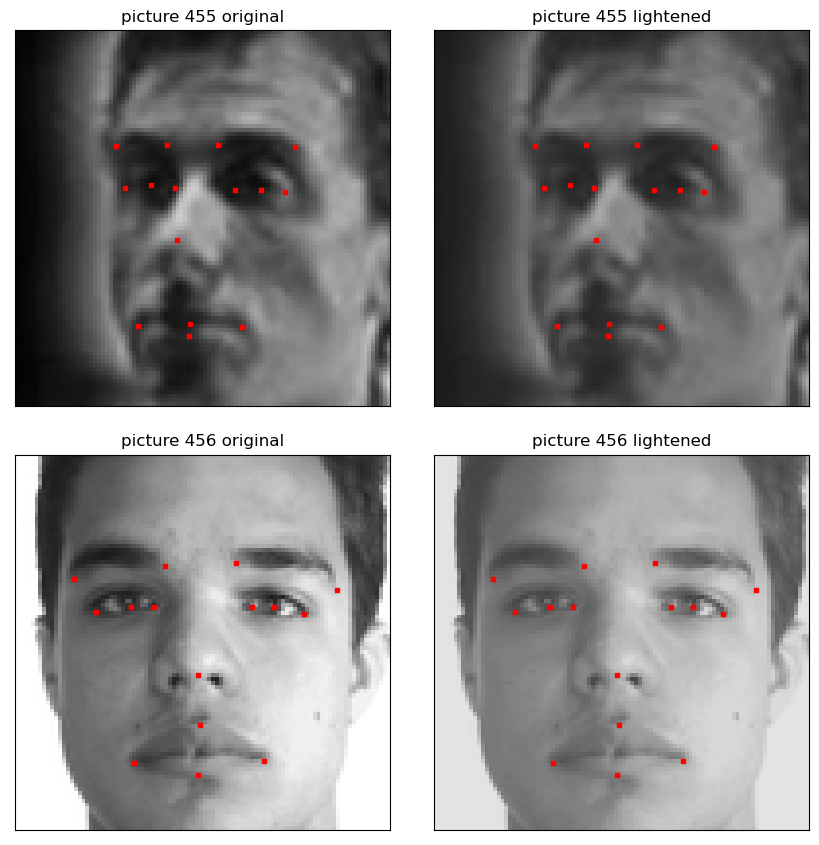

In [47]:
# augment data
trainX_4, trainY_4 = aug.aug(params, _trainX_4, _trainY_4, maxrotate=20, contrast_alpha=0.7)

In [48]:
# build a param string
   
param_str = ut.build_param_str(params, n = trainX_4.shape[0])

In [49]:
trainX_4.shape

(8560, 96, 96, 1)

./saved_models/Model_4_02_M1W1R1C1_2500_30_8560


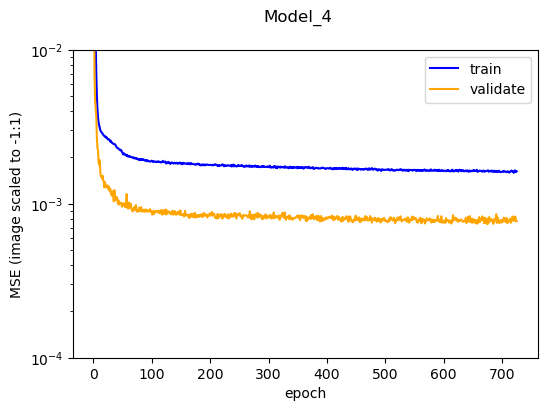

268/268 [==============================] - 3s 10ms/step - loss: 5.9440e-04
1.1702537384356506 1.3024543621411062


In [50]:
def model_4(num_y_features):
    
    d_rate = 0.5
       

    model = Sequential(name = 'Model_4')
    
    # trying to condense the data somewhat, but using a lot of filters to start and very large convolution kernel 
    #model.add(Conv2D(128, 12, activation='relu', kernel_initializer='he_uniform', padding="same", input_shape=(96, 96, 1)))
    model.add(Conv2D(128, 12, activation='selu', kernel_initializer='lecun_normal', padding="same", input_shape=(96, 96, 1)))
    model.add(BatchNormalization())  
    model.add(MaxPooling2D((2, 2)))
    
    
    model.add(Conv2D(128, 2, activation='selu', kernel_initializer='lecun_normal', padding="same"))
    model.add(BatchNormalization())  
    model.add(Conv2D(128, 2, activation='selu', kernel_initializer='lecun_normal', padding="same"))
    model.add(BatchNormalization())     
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())             

    model.add(Conv2D(256, 2, activation='selu', kernel_initializer='lecun_normal', padding="same"))
    model.add(BatchNormalization())  
    model.add(Conv2D(256, 2, activation='selu', kernel_initializer='lecun_normal', padding="same"))
    model.add(BatchNormalization())     
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())             
              
    model.add(Flatten())   
    model.add(BatchNormalization())            
    
    #model.add(Dense(256, activation = 'relu')) 
    model.add(Dense(256, activation = 'selu', kernel_initializer='lecun_normal'))   
    model.add(BatchNormalization())    
    model.add(Dropout(rate = d_rate))
            
    model.add(Dense(128, activation = 'selu', kernel_initializer='lecun_normal'))     
    model.add(BatchNormalization())    
    model.add(Dropout(rate = d_rate))
   
    model.add(Dense(64, activation = 'selu', kernel_initializer='lecun_normal'))   
    model.add(BatchNormalization())    
    model.add(Dropout(rate = d_rate))
              
    model.add(Dense(num_y_features))
                        
    opt = keras.optimizers.Nadam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")          
    #opt = SGD(lr=0.01, momentum=0.9)
    
    model.compile(loss = "mean_squared_error", optimizer = opt)
    #print(model.summary())
    return(model)

build_model = False   # set to false if you want to reload an existing model

model_4 = model_4(num_y_features)
model_4, hist_4 = ut.run_model(model_4, trainX_4, trainY_4, valX_4, valY_4, params, build_model, model_dir_name, param_str)
diag_4 = ut.return_diagnostics(model_4, hist_4, trainX_4, trainY_4, valX_4, valY_4)



In [51]:
y_pred_4 = model_4.predict(testX_4)
test_rmse_4 = np.sqrt(np.mean((y_pred_4 - testY_4)**2))*48

m_list, d_list, t_list = [model_4, model_3, model_2, model_1], [diag_4, diag_3, diag_2, diag_1], [test_rmse_4, test_rmse_3, test_rmse_2, test_rmse_1]
ut.print_diagnostics(m_list, d_list, t_list)



Model Comparison

			     |   Model_4   |   Model_3   |   Model_2   |   Model_1   |
______________________________________________________________________________________
         Train RMSE (pixels) |        1.17 |        1.13 |        1.08 |        1.41 |
    Validation RMSE (pixels) |        1.30 |        1.45 |        1.66 |        2.18 |
          Test RMSE (pixels) |        1.13 |        1.59 |        1.92 |        2.32 |
______________________________________________________________________________________
      Loss Ratio (Val/Train) |        1.11 |        1.29 |        1.53 |        1.55 |
      Loss Ratio (Test/Train)|        0.96 |        1.42 |        1.78 |        1.64 
                             |             |             |             |             |
		      Epochs |         725 |         209 |         506 |         454 |
        Trainable Parameters |  10,101,342 |  10,076,382 |   1,318,587 |   1,970,030 |
___________________________________________________________

### **Model 4 Analysis**

Model 4, with the augmented dataset, resulted in a significant improvement. The RMSE on the validation data improved 10%,<br> while the improvement on the test data was 29%. An RMSE as low as 1.13 seemed suspiciously low to us, which was somewhat<br> confirmed when we submitted our test results to Kaggle. This resulted in a 31st percentile (53/175) on the private leaderboard. <br>While this is certainly respectable, one might have expected a better performance on the `test.csv` file, given an RMSE on <br>test of 1.13. It appears we may have modeled features that were more specific to *our* test set than to the test data provided by<br> Kaggle. 

- The two changes we made to our model between Model 4 and Model 3 was that we added a third dense layer paired with <br>another 50% Dropout layer and we changed the learning rate from .01 to .001. Between these changes and the 4x increase <br>in the size of the dataset, the train time of this model was ~15x longer than for Model 3. 

- The reduction in the learning rate provided a notable reduction in the volatility of the validation results. 


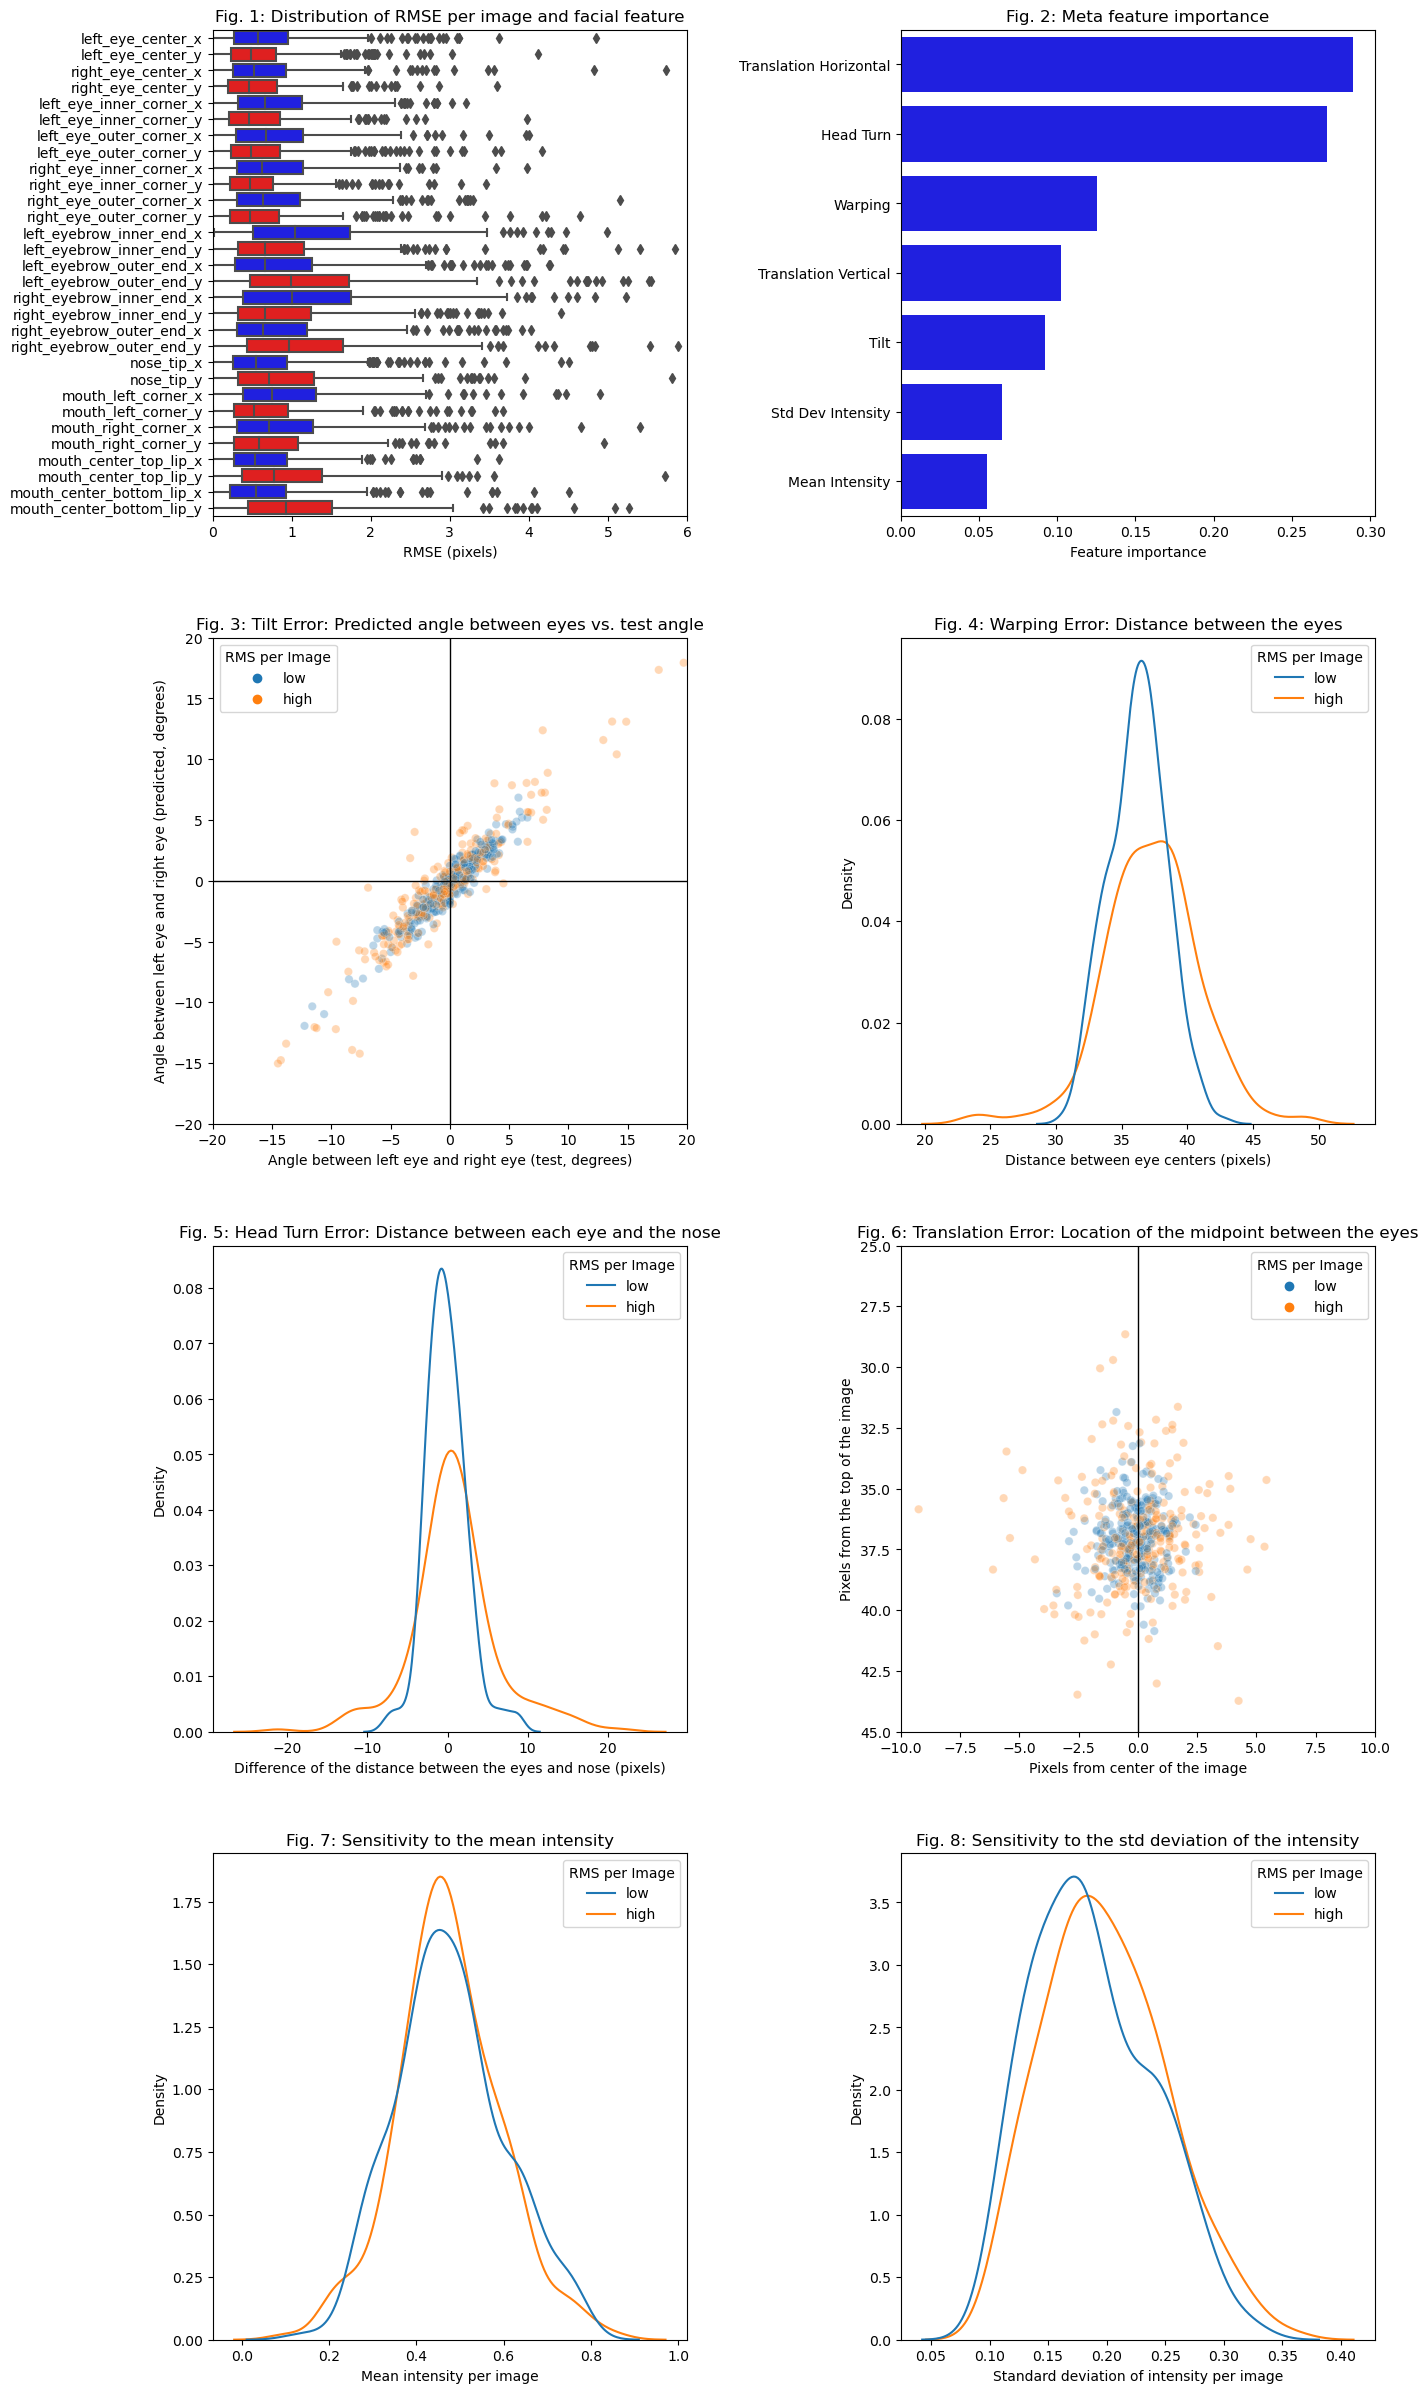

In [52]:
X_test_4, y_test_4 = ut.subset_data_JM(df, test = False, n_complete=2140, n_partial=0, cols = None)
X_test_4, y_test_4 = X_test_4[-500:], y_test_4[-500:]
X_test_square_4 = ut.make_square(X_test_4)
y_pred_4 = model_4.predict(X_test_square_4)
a, b = ut.error_analysis(X_test_4, y_test_4, y_pred_4, facial_feature_vec, plot_results = True)

### Model 4 Error Discussion:

One observation that comes out is that the RMSE error distributions are much more uniform across facial features than the <br>previous models. The model has done a better job of reducing the errors on the features with the largest errors.  Again, the<br> meta feature importance is similar to prior models. Additionally, given the  relatively frequent errors associated with horizontal <br>and vertical variance, it appears we might have benefitted by added augmentations that provided those sort of horizontal<br>and vertical shifts.



## **Model 5 - Two step CNN**

Model 5 makes use of almost all the image data (7,000 out of 7,049 images).  Of the 7,000 images, 2,140 have complete (30) facial<br> feature information, while the remaining 4,860 have 8 of the same features available, we'll call these images incomplete.

### Part 1:

The model is a two step CNN model.  The first step, **Part 1**, applies Model 4 (CNN) to the incomplete images, training the model on <br>identifying the 8 common features (eye centers, tip of the nose, mouth center bottom lip).  Once trained, we apply the fitted model<br> to the remaining images in the complete feature dataset.

### Part 2:
At this step, we process the complete images.  The images are preprocessed with the model from **Part 1** to develop initial predictions<br> for the 8 facial features.  Those predictions are passed through the **Error Analysis** function that returns five additional meta features: <br>tilt, head turn,  translation and warping.  

The final model has two input data streams: the 13 preprocessed features (8 + 5) and the raw images.  The preprocessed features run <br>through a simple dense layer while the raw images run through Model 4 (CNN).  The results are combined and flow through a few more <br>layers, ultimately producing 30 output features.


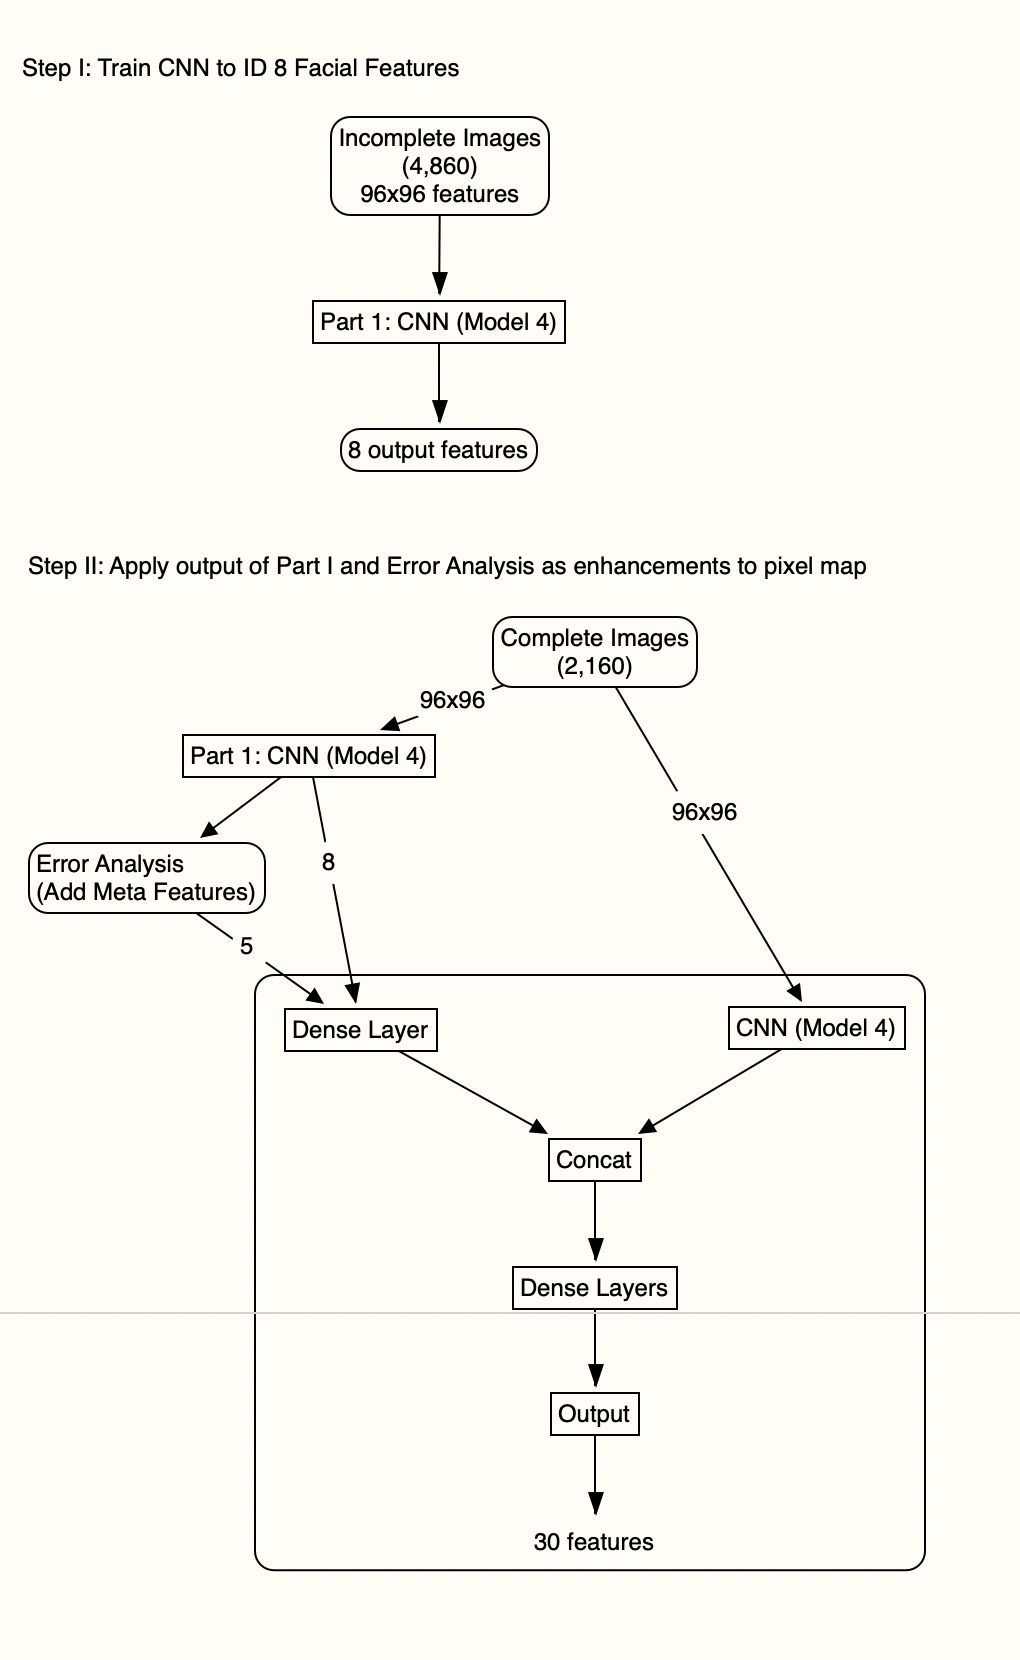

In [53]:
Image("model5_diagram.png")

## Load and prep the data 

In [54]:
importlib.reload(ut)
importlib.reload(aug)

<module 'utils_augment' from '/home/jupyter/w207_final_project/W207_final_project/utils_augment.py'>

In [55]:
model_dir_name ='./submit_models/'

In [56]:
# set up the parameter dictionary

params = {
    'validation_fraction': 0.2,
    'augment': {'mirror': False, 'warp': False, 'rotate': False},
    'epochs': 100,
    'num_y_features': np.nan       # for now, set to nan
}


In [57]:
# load all the data

test = False
fname = FTEST if test else FTRAIN

df = ut.load_data(fname = fname ,complete = False)
print(df.shape)

training.csv
(7049, 31)


In [58]:
# set up the facial feature vectors

# full feature vec

full_facial_feature_vec = list(df.columns[:-1])

# sub feature vec

sub_facial_feature_vec = ['left_eye_center_x', 'left_eye_center_y', 
                          'right_eye_center_x', 'right_eye_center_y', 
                          'nose_tip_x','nose_tip_y',
                          'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']

# find the indices of the full_facial_feature_vec that overlap with sub_facial_feature_vec

full_2_sub_indices = np.argwhere(np.in1d(full_facial_feature_vec, sub_facial_feature_vec)).reshape(-1)
print(full_2_sub_indices)

[ 0  1  2  3 20 21 28 29]


In [59]:
# given all the data, we'll split it into two parts:
# 1. images with all the 30 features
# 2. images not part of (1) but have the common, highly prevelant 8 features at a minimum

df_full, df_inc = ut.split_data_by_completeness(df, cols = sub_facial_feature_vec)
print(df_full.shape, df_inc.shape)

(2140, 31) (4860, 9)


In [60]:
# split the data into X and Y components
# transform their scale from 0 to 95 to -1 to 1
# shuffle the returned data

df_full_X, df_full_Y = ut.split_xy(df_full, test = False)
df_inc_X, df_inc_Y = ut.split_xy(df_inc, test = False)

print(df_full_X.shape, df_full_Y.shape, df_inc_X.shape, df_inc_Y.shape)

(2140, 9216) (2140, 30) (4860, 9216) (4860, 8)


In [61]:
# n_train_val_full will be the size of our working data set for part 2

n_train_val_inc = 4500
n_val_inc = int(params['validation_fraction'] * n_train_val_inc)
n_train_inc = n_train_val_inc - n_val_inc

print(n_train_val_inc, n_train_inc, n_val_inc)

# n_train_val_full will be the size of our working data set for part 2

n_train_val_full = 1500
n_val_full = int(params['validation_fraction'] * n_train_val_full)
n_train_full = n_train_val_full - n_val_full

print(n_train_val_full, n_train_full, n_val_full)

# once we've flushed out the process, we'll change the values for the inc dota


4500 3600 900
1500 1200 300


In [62]:
# split the data into train, val and test

# complete facial features:

trainX_full = df_full_X[:n_train_full]
trainY_full = df_full_Y[:n_train_full]

valX_full = df_full_X[n_train_full:(n_train_val_full)]
valY_full = df_full_Y[n_train_full:(n_train_val_full)]

testX_full = df_full_X[n_train_val_full:]
testY_full = df_full_Y[n_train_val_full:]

# incomplete, but contain critical sub features:

trainX_inc = df_inc_X[:n_train_inc]
trainY_inc = df_inc_Y[:n_train_inc]

valX_inc = df_inc_X[n_train_inc:(n_train_val_inc)]
valY_inc = df_inc_Y[n_train_inc:(n_train_val_inc)]

testX_inc = df_inc_X[n_train_val_inc:]
testY_inc = df_inc_Y[n_train_val_inc:]

# make the X's square for the CNN:

trainX_full_sq =  ut.make_square(trainX_full)
valX_full_sq =  ut.make_square(valX_full)
testX_full_sq =  ut.make_square(testX_full)

trainX_inc_sq =  ut.make_square(trainX_inc)
valX_inc_sq =  ut.make_square(valX_inc)
testX_inc_sq =  ut.make_square(testX_inc)

## Set up the models

## Analysis, Part 1:


### Fit the first stage model with 8 features on the incomplete data set

In [63]:
# set up the params
params['num_y_features'] = len(sub_facial_feature_vec)  
param_str = ut.build_param_str(params, n = n_train_val_inc)
print(param_str)

_02_M0W0R0_100_8_4500


Model: "model_jm4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 96, 96, 128)       18560     
_________________________________________________________________
batch_normalization_32 (Batc (None, 96, 96, 128)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 128)       65664     
_________________________________________________________________
batch_normalization_33 (Batc (None, 48, 48, 128)       512       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 128)       65664     
_________________________________________________________________
batch_normalization_34 (Batc (None, 48, 48, 128)       51

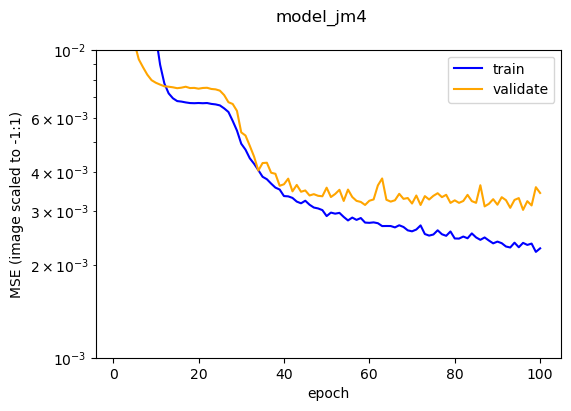

113/113 [==============================] - 1s 9ms/step - loss: 0.0011
1.6267847475480006 2.809789591357828


In [64]:
build_model = False   # set to false if you want to reload an existing model
model_pre_jm4 = ut.model_jm4(params['num_y_features'])
model_pre_jm4, hist_pre_jm4 = ut.run_model(model_pre_jm4, 
                                   trainX_inc_sq, trainY_inc, 
                                   valX_inc_sq, valY_inc, 
                                   params, build_model, 
                                   model_dir_name, param_str)
#diag_pre_jm4 = ut.return_diagnostics(model_pre_jm4, hist_pre_jm4)

diag_pre_jm4 = ut.return_diagnostics(model_pre_jm4, hist_pre_jm4,trainX_inc_sq, trainY_inc, valX_inc_sq, valY_inc )

### Process the validation or test data (only once we're done)

In [65]:
we_are_done = True
if we_are_done:
    model_pre_jm4.evaluate(testX_inc_sq, testY_inc)
    y_pred_inc = model_pre_jm4.predict(testX_inc_sq)
    model_pre_rms = ut.calc_model_rmse_pixels(testY_inc, 
                                          y_pred_inc, 
                                          sub_facial_feature_vec)

else:
    model_pre_jm4.evaluate(valX_inc_sq, valY_inc)
    y_pred_inc = model_pre_jm4.predict(valX_inc_sq)
    model_pre_rms = ut.calc_model_rmse_pixels(valY_inc, 
                                          y_pred_inc, 
                                          sub_facial_feature_vec)

print(model_pre_rms)   

12/12 [==============================] - 0s 9ms/step - loss: 0.0039
2.9909425377845764


## 2. Run the full featured data through the pre-model 

Given the preprocessed model, run the full featured data through it to have initial values for the 8 features of the new data

In [66]:
# prep the meta data:

y_pred_pre_train = model_pre_jm4.predict(trainX_full_sq)
y_pred_pre_val = model_pre_jm4.predict(valX_full_sq)
y_pred_pre_test = model_pre_jm4.predict(testX_full_sq)
print(y_pred_pre_train.shape)
print(y_pred_pre_val.shape)
print(y_pred_pre_test.shape)

(1200, 8)
(300, 8)
(640, 8)


Run the predictions of the first model (model_pre_jm4) through the error analysis

In [67]:
# Extract meta features from the error analysis
_, train_full_meta = ut.error_analysis(trainX_full, trainY_full[:,full_2_sub_indices], y_pred_pre_train, sub_facial_feature_vec, plot_results = False, use_predicted = True)
_, val_full_meta =   ut.error_analysis(  valX_full,   valY_full[:,full_2_sub_indices], y_pred_pre_val,   sub_facial_feature_vec, plot_results = False, use_predicted = True)
if we_are_done:
    _, test_full_meta =  ut.error_analysis( testX_full,  testY_full[:,full_2_sub_indices], y_pred_pre_test,  sub_facial_feature_vec, plot_results = False, use_predicted = True)

In [68]:
# filter out the composite meta features of interest:
composite_meta_features = ['angle_pred', 'd_Leye_Reye', 'head_turn', 'mid_x', 'mid_y']

# rescale the values to get back to the -1 to 1 units.  For the angle, divide by 45 (we haven't seen more that 20)
scale_df = pd.DataFrame([[45., 48., 48., 48., 48.]], columns = composite_meta_features)

train_meta_comp = np.array(
    train_full_meta[composite_meta_features].div(scale_df.iloc[0])
)
val_meta_comp = np.array(
    val_full_meta[composite_meta_features].div(scale_df.iloc[0])
)
if we_are_done:
    test_meta_comp = np.array(
        test_full_meta[composite_meta_features].div(scale_df.iloc[0])
    )

Combine the meta features into a single np.array

In [69]:
# blend the meta_composite with the y locations
combine_meta = True
if combine_meta:
    train_meta = np.c_[y_pred_pre_train, train_meta_comp]
    val_meta   = np.c_[y_pred_pre_val,   val_meta_comp]
    if we_are_done:
        test_meta   = np.c_[y_pred_pre_test,   test_meta_comp]

else:
    train_meta = y_pred_pre_train
    val_meta   = y_pred_pre_val
    if we_are_done:
        test_meta = y_pred_pre_test
    
print(train_meta.shape, val_meta.shape)

(1200, 13) (300, 13)


### Set up the CNN's and model merging structure

In [70]:
def create_cnn_model(num_y_features, input_img):
    '''Joes model 4'''

    d_rate = 0.5
   
        
    # trying to condense the data somewhat, but using a lot of filters to start and very large convolution kernel 
    
    model = Conv2D(128, 12, activation='selu', kernel_initializer='lecun_normal', padding="same", input_shape=(96, 96, 1))(input_img)
    model = BatchNormalization()(model)
    model = MaxPooling2D((2, 2))(model)
        
    model = Conv2D(128, 2, activation='selu', kernel_initializer='lecun_normal', padding="same")(model)
    model = BatchNormalization()(model)  
    model = Conv2D(128, 2, activation='selu', kernel_initializer='lecun_normal', padding="same")(model)
    model = BatchNormalization()(model)
    model = MaxPooling2D((2, 2))(model)
    model = BatchNormalization()(model)          

    model = Conv2D(256, 2, activation='selu', kernel_initializer='lecun_normal', padding="same")(model)
    model = BatchNormalization()(model)
    model = Conv2D(256, 2, activation='selu', kernel_initializer='lecun_normal', padding="same")(model)
    model = BatchNormalization()(model)    
    model = MaxPooling2D((2, 2))(model)
    model = BatchNormalization()(model)       
              
    model = Flatten()(model)   
    model = BatchNormalization()(model) 
    
    model = Dense(256, activation = 'selu', kernel_initializer='lecun_normal')(model)
    model = BatchNormalization()(model)    
    model = Dropout(rate = d_rate)(model)
   
    model = Dense(64, activation = 'selu', kernel_initializer='lecun_normal')(model)   
    model = BatchNormalization()(model)    
    model = Dropout(rate = d_rate)(model)
              
    model = Dense(num_y_features)(model)
                        
    return(model)


In [71]:
def model_d4(num_y_features, image_shape, meta_shape):
    
    # dual path of Joe's model 4

    d_rate = 0.2
    n_nodes = 125
        
    input_image = Input(shape = image_shape, name = 'image')
    input_meta  = Input(shape = [meta_shape], name = 'meta')

    cnn_model = create_cnn_model(num_y_features, input_image)

    # set up a simple meta model:
    
    meta_model = Dense(n_nodes, activation = 'relu')(input_meta)
    meta_model = BatchNormalization()(meta_model)
#     meta_model = Dense(n_nodes,  activation = 'relu')(meta_model)
#     meta_model = BatchNormalization()(meta_model)

    # bring it all together
    
    concat  = concatenate([cnn_model, meta_model])

    hidden1c = Dense(n_nodes,  activation = 'relu')(concat)
    hidden1c_d = Dropout(rate = d_rate)(hidden1c)
    hidden1c_b = BatchNormalization()(hidden1c_d)
    hidden2c = Dense(n_nodes,  activation = 'relu')(hidden1c_b)
    hidden2c_d = Dropout(rate = d_rate)(hidden2c)
    hidden2c_b = BatchNormalization()(hidden2c_d)

    # setup the output
    
    output  = Dense(num_y_features)(hidden2c_b)
 
    model = Model(inputs = [input_image, input_meta], outputs = [output], name = 'model_d4')

    opt = Nadam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")          
    #opt = SGD(lr=0.01, momentum=0.9)
    
    model.compile(loss = "mean_squared_error", optimizer = opt)
    print(model.summary())

    return(model)


#### Set up the models to run them

In [72]:
# set up the params
params['epochs'] = 500

params['num_y_features'] = train_meta.shape[1]
param_str = ut.build_param_str(params, n = n_train_val_full)
print(param_str)

_02_M0W0R0_500_13_1500


In [73]:
image_shape = trainX_full_sq.shape[1:]
meta_shape = train_meta.shape[1]
num_y_features = len(full_facial_feature_vec)
print(num_y_features, image_shape, meta_shape)

30 (96, 96, 1) 13


Model: "model_d4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 96, 96, 128)  18560       image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 96, 96, 128)  512         conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 48, 48, 128)  0           batch_normalization_42[0][0]     
___________________________________________________________________________________________

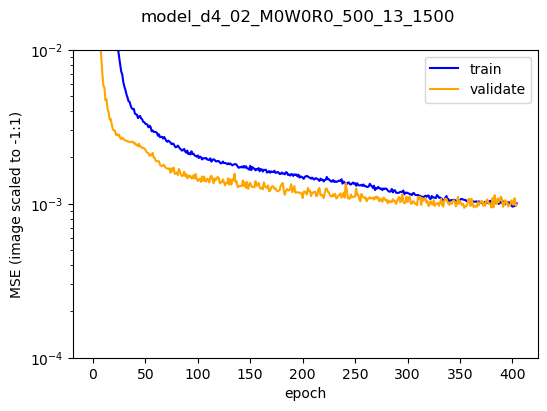

38/38 [==============================] - 0s 10ms/step - loss: 4.8546e-04
1.0575954403318901 1.4711967794812084


In [74]:
build_model = False   # set to false if you want to reload an existing model

model_d4 = model_d4(num_y_features, image_shape, meta_shape)
model_d4, hist_d4 = ut.run_dual_models(model_d4, 
                                 trainX_full_sq, train_meta, trainY_full, 
                                 valX_full_sq,   val_meta,   valY_full, 
                                 params, build_model, 
                                 model_dir_name, param_str)
#diag_d4 = ut.return_diagnostics(model_d4, hist_d4)
diag_d4 = ut.return_diagnostics(model_d4, hist_d4, [trainX_full_sq,train_meta], trainY_full,[valX_full_sq,val_meta], valY_full )

In [75]:
if we_are_done:
    model_d4.evaluate([testX_full_sq, test_meta], testY_full)
    y_pred = model_d4.predict([testX_full_sq, test_meta])
else:
    model_d4.evaluate([valX_full_sq, val_meta], valY_full)
    y_pred = model_d4.predict([valX_full_sq, val_meta])

20/20 [==============================] - 0s 10ms/step - loss: 0.0010


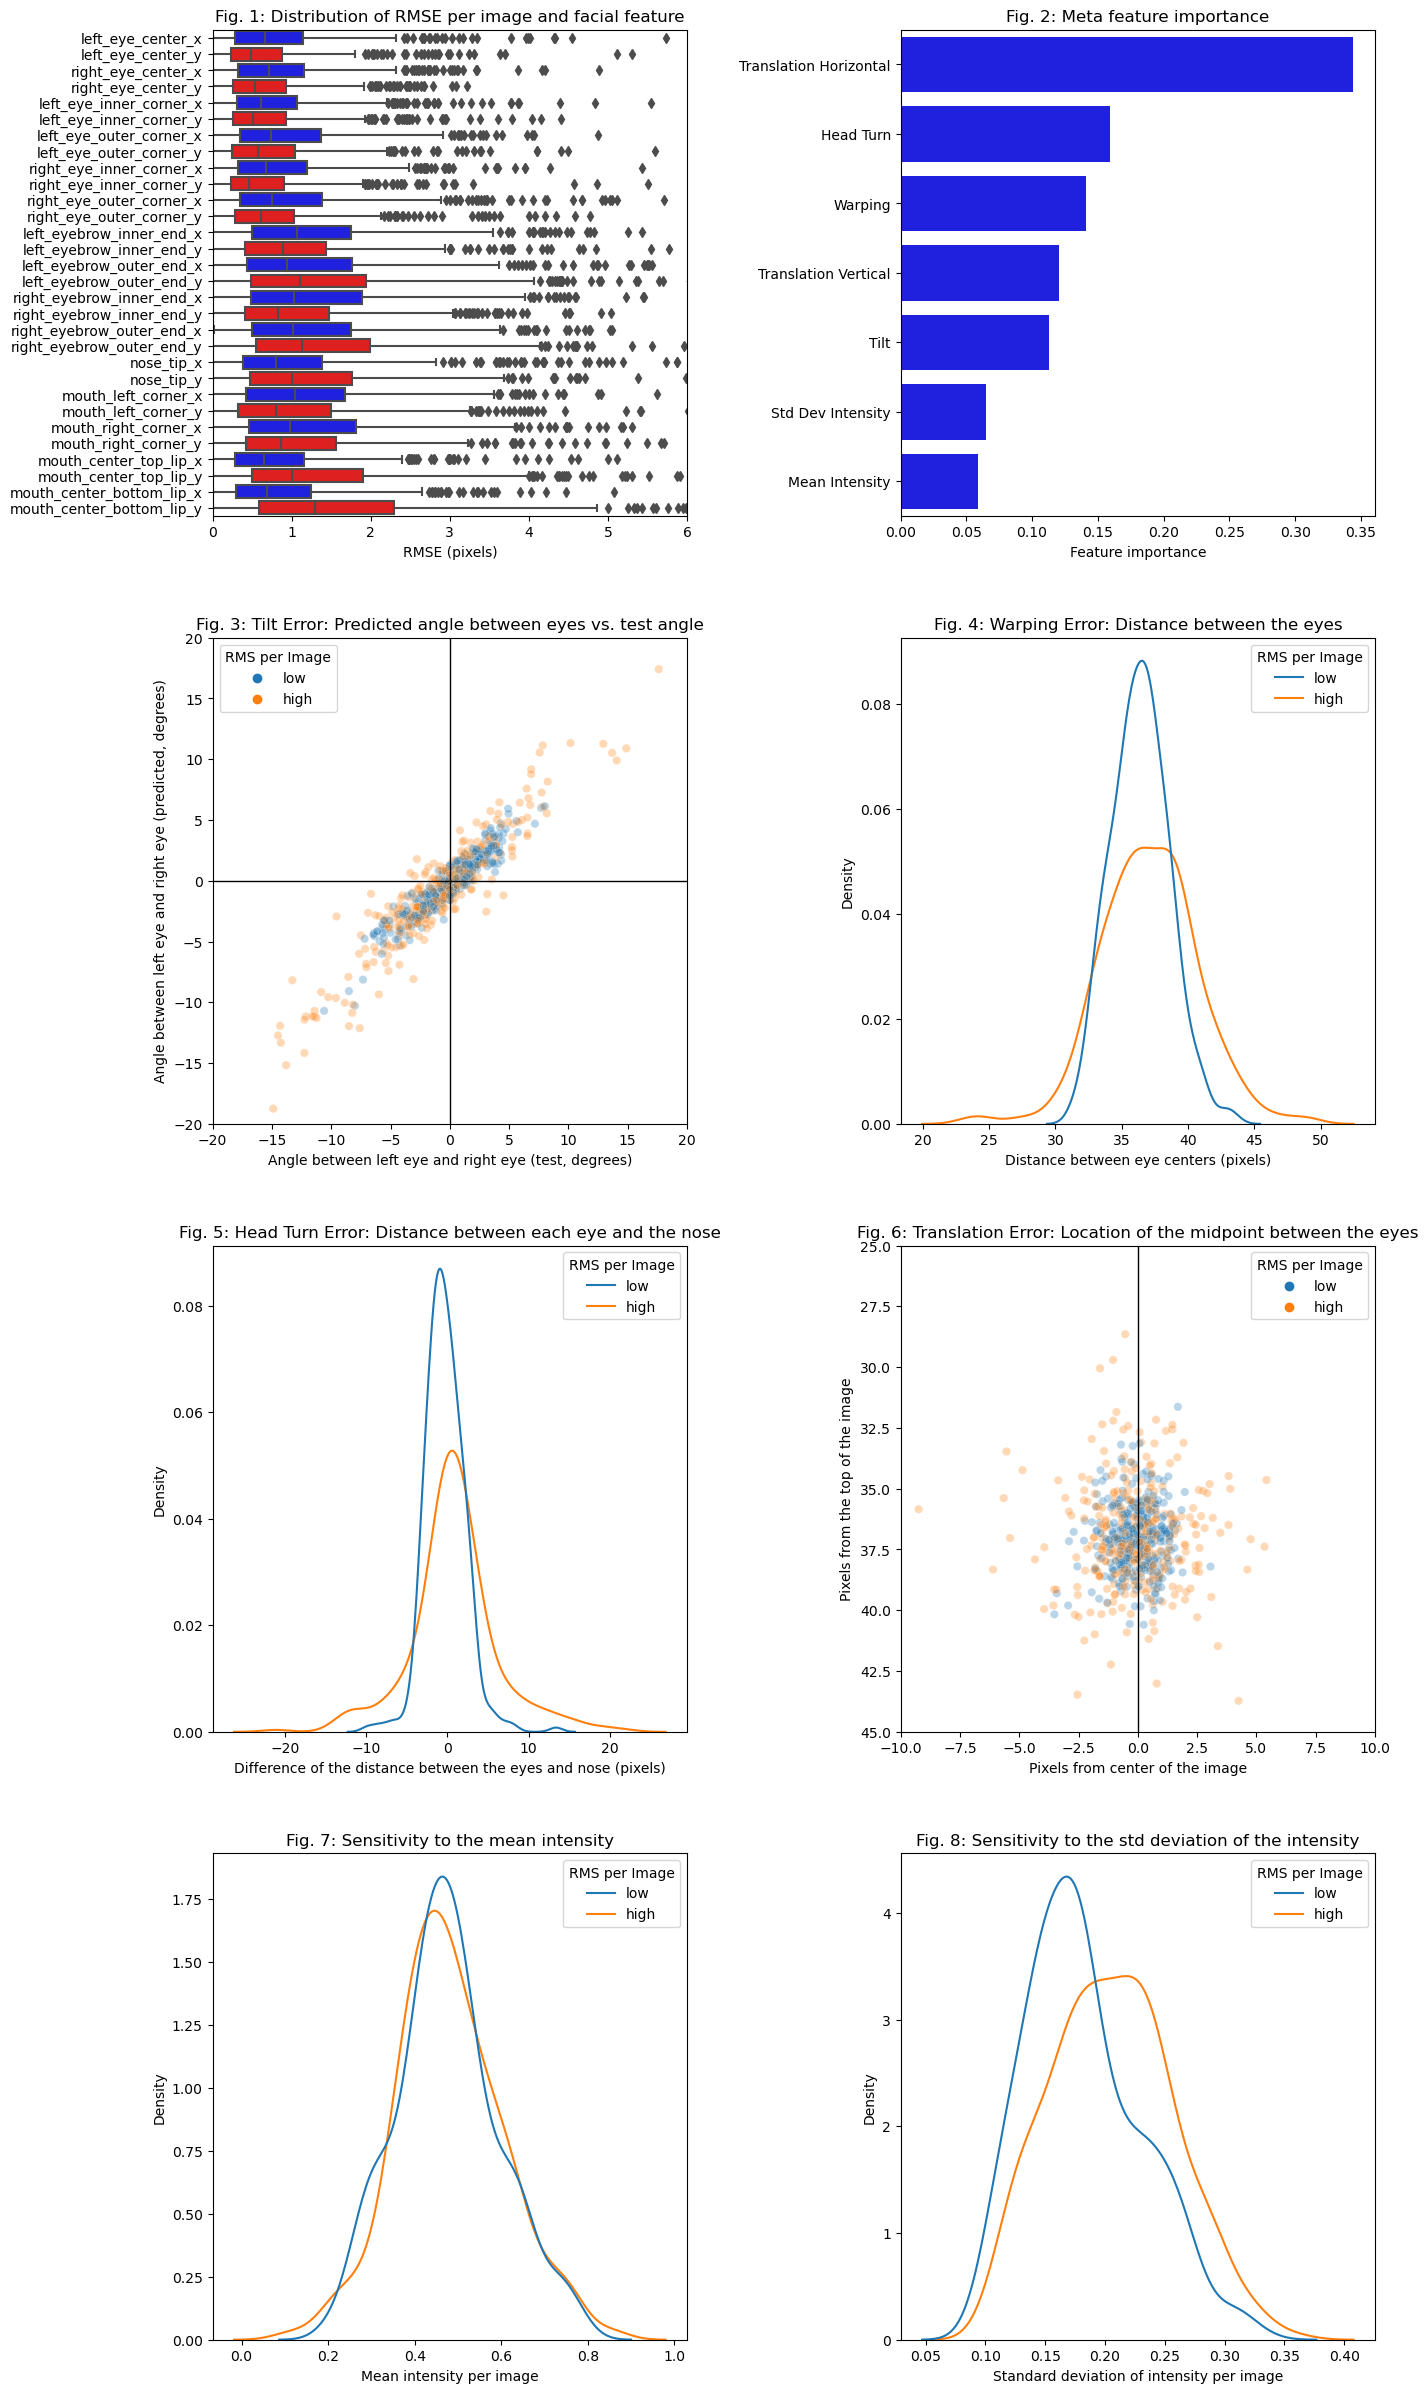

In [76]:
if we_are_done:
    _, _ = ut.error_analysis(testX_full, testY_full, y_pred, full_facial_feature_vec, plot_results = True, use_predicted = False)
else:
    _, _ = ut.error_analysis(valX_full,   valY_full, y_pred, full_facial_feature_vec, plot_results = True, use_predicted = False)


In [77]:
y_pred_pre_jm4 = y_pred_inc

test_rmse_pre_jm4 = np.sqrt(np.mean((y_pred_pre_jm4 - testY_inc)**2))*48
y_pred_d4 = y_pred
test_rmse_d4 = np.sqrt(np.mean((y_pred_d4 - testY_full)**2))*48

m_list, d_list, t_list = [model_d4, model_4, model_3, model_2, model_1], [diag_d4, diag_4, diag_3, diag_2, diag_1], [test_rmse_d4, test_rmse_4, test_rmse_3, test_rmse_2, test_rmse_1]
print("\n\n")
ut.print_diagnostics(m_list, d_list, t_list)






Model Comparison

			     |   model_d4  |   Model_4   |   Model_3   |   Model_2   |   Model_1   |
____________________________________________________________________________________________________
         Train RMSE (pixels) |        1.06 |        1.17 |        1.13 |        1.08 |        1.41 |
    Validation RMSE (pixels) |        1.47 |        1.30 |        1.45 |        1.66 |        2.18 |
          Test RMSE (pixels) |        1.53 |        1.13 |        1.59 |        1.92 |        2.32 |
____________________________________________________________________________________________________
      Loss Ratio (Val/Train) |        1.39 |        1.11 |        1.29 |        1.53 |        1.55 |
      Loss Ratio (Test/Train)|        1.44 |        0.96 |        1.42 |        1.78 |        1.64 
                             |             |             |             |             |             |
		      Epochs |         404 |         725 |         209 |         506 |         454 |
   

### **Model 5 Analysis**

We developed a technique to leverage the images with incomplete feature information.  We also developed the infrastructure to <br>blend additional  features, to the baseline CNN.  This is a demonstration of the flexibility of the framework. 

In its current state, Model 5 underperforms Model 4, but is on par with Model 3.  The RMSE distributions by facial feature are similar <br>to those of Model 3.  Perhaps this shouldn’t be too shocking since Model 5 contains a Model 3 in its core.  This leads us to question <br>the value of the additional complexity of Model 5.  At this point, it doesn’t appear like we’re benefiting from the extra images (in the<br> pre-model) and the meta features.  Perhaps the issue is due to how we are blending the dual models together.  There are several <br>areas to explore further, including bringing in the 8 features as a matrix (instead of a vector), preserving the spatial relationships as<br> well as exploring additional meta features.  

Future research could focus on which features are most beneficial to extract in the pre-model (the subset of facial features).  Perhaps,<br> those features with larger uncertainties could be left out.  


### Model 5 Error Discussion:





In Model 5, we observe larger errors than in Model 4, but very similar in overall performance and with similar errors with respect to meta <br>features as Model 3. 


## **Conclusion and Future Direction**

This was both an extremely challenging and extremely rewarding project. Understanding the origins of neural networks and their<br>conceptual relationship to neurons as well as the evolution of CNNs and their relationship to visual perception has been fascinating. 

It was one thing to hear how important feature engineering was, but quite another to actually implement it and see how it impacted <br>our results. Just as interesting was error analysis. You hear that good data scientists (or, how about just 'scientists') are obsessed<br> with analyzing errors. This project made that process a little more tangible. We identified rotations as a source of error and added <br>rotated images to our dataset to train the model. That helped address that issue and then we saw that vertical and horizontal <br>translation errors were a source of error. If we had had more time, we would have augmented our dataset with *those* sorts of images.

There were a number of paths we wished we could have explored:
- Augmentations we should have attempted but didn't because of time<br>

- Different modeling approaches. We discovered fairly late in the process that some of the best solutions to this problem were<br> ensembles that modeled subsets of the features before assembling them at the end. That would be an interesting avenue. 
- Early in the course something along the lines *'more data will often beat a better model'* was suggested. Sure, that's probably <br>true. But it would be better to have a lot of data *and* a better model. 
- We also wrote a custom loss function that only calculated MSE for features that were present. That loss function, combined with<br> weights to address the feature imbalance, would have been an interesting path to explore that would have used all the labeled data.

- Our Model 4 felt a bit like a brute force approach, where we threw a lot of heavily augmented data at a relatively complex model<br> and attempted too tune it effectively enough that it would learn well without overfitting. Which it did. However, it would interesting<br> to see *how little* data could be used to achieve the same results. For example, depthwise max pooling of rotational convolutional<br> layers might *learn* to recognize rotated images with just a well specified model rather than a dataset augmented with rotated<br> images. 
